# USA Projects: Food waste treatment and co-digestion

In [90]:
library(ggplot2)
library(tidyverse)
library(GGally)
library(VIM)
library(reshape2)
library(gridExtra)
library(missForest)
library(rpart)
library(randomForest)
library(caret)
library(ranger)
library(rpart.plot)
library(gbm)
library(MASS)
library(Benchmarking)

## 1. Data preparation, imputation, and vizualization

#### Data cleaning and imputation

In [92]:
# Read in data
df <- read.csv("DataUSA.csv", na.strings="")

In [93]:
# Change variable types (numeric or factor)
df$Cattle <- as.factor(df$Cattle)
df$Dairy <- as.factor(df$Dairy)
df$Poultry <- as.factor(df$Poultry)
df$Swine <- as.factor(df$Swine)
df$Codigestion <- as.factor(df$Codigestion)
df$CodigestionFW <- as.factor(df$CodigestionFW)


 Variables sorted by number of missings: 
             Variable Count
     ElectricitykWhyr 0.250
 EmissionRedMetricTpy 0.025
          ProjectType 0.000
         DigesterType 0.000
               Cattle 0.000
                Dairy 0.000
              Poultry 0.000
                Swine 0.000
         CattleAmount 0.000
          DairyAmount 0.000
        PoultryAmount 0.000
          SwineAmount 0.000
          Codigestion 0.000
        CodigestionFW 0.000


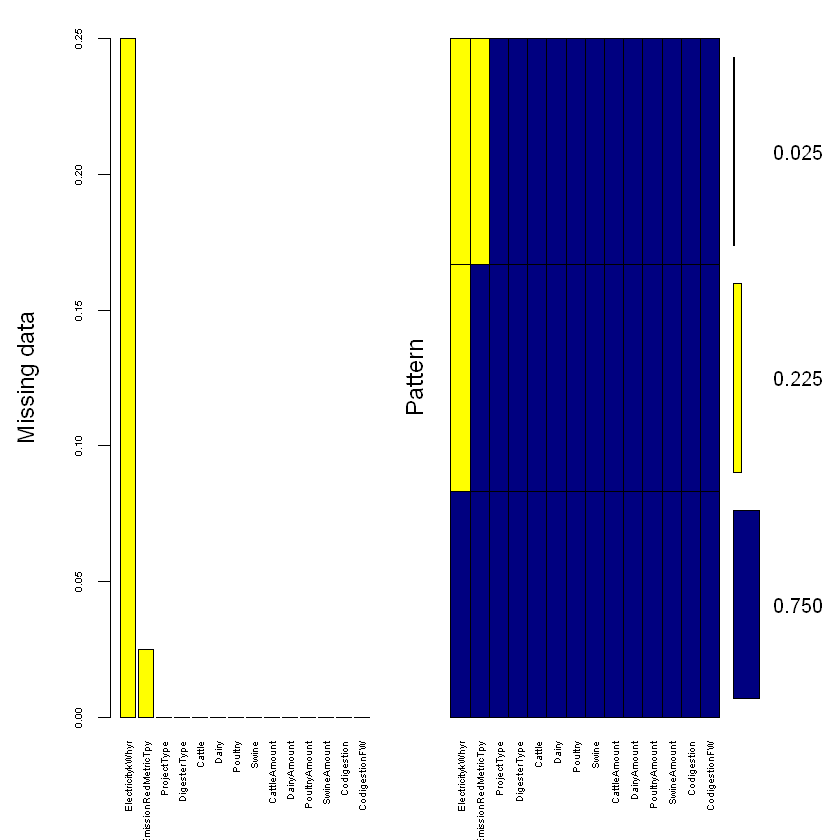

In [95]:
# Test for missing values and visualize  
missVals_plot <- aggr(df, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df), cex.axis=.5,
                    gap=3, ylab=c("Missing data","Pattern"))

In [97]:
# Imputation of missing values with random forest
df_rfImp <- missForest(df)
df2 <- df_rfImp$ximp

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!


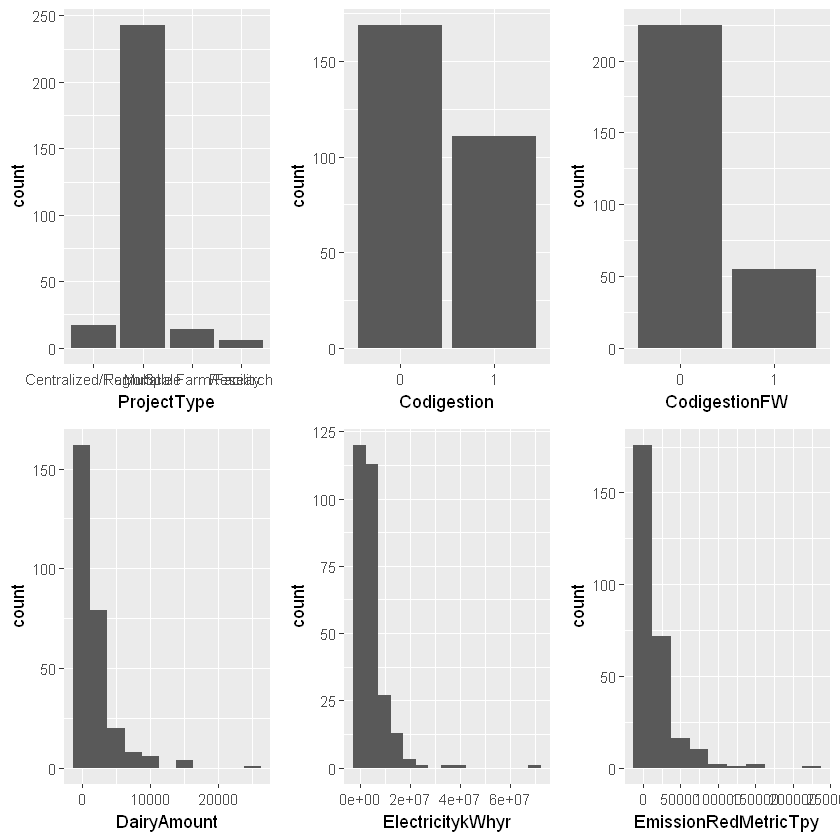

In [117]:
# Visualize the distributions of our variables
h2 <- ggplot(data = df2, aes(x = Codigestion)) + geom_bar()
h3 <- ggplot(data = df2, aes(x = CodigestionFW)) + geom_bar()

h4 <- ggplot(data = df2, aes(x = DairyAmount)) + geom_histogram(binwidth=2500)
h5 <- ggplot(data = df2, aes(x = ElectricitykWhyr)) + geom_histogram(binwidth=5000000)
h6 <- ggplot(data = df2, aes(x = EmissionRedMetricTpy)) + geom_histogram(binwidth=25000)

# Place the plot objects into a grid
grid.arrange(h1,h2,h3,h4,h5,h6,ncol=3)

In [119]:
df2[c("ProjectType","Codigestion",
             "CodigestionFW","DairyAmount",
             "ElectricitykWhyr","EmissionRedMetricTpy")]

ProjectType,Codigestion,CodigestionFW,DairyAmount,ElectricitykWhyr,EmissionRedMetricTpy
Farm Scale,0,0,0,749832.8,4002.00
Farm Scale,0,0,15000,5256000.0,138971.00
Farm Scale,0,0,4000,4467600.0,39353.00
Farm Scale,0,0,15500,16206000.0,108050.00
Farm Scale,0,0,1700,4204800.0,15014.00
Farm Scale,0,0,9700,7600000.0,82693.00
Multiple Farm/Facility,0,0,7000,6700000.0,60585.00
Farm Scale,1,0,1700,1830000.0,13204.00
Farm Scale,0,0,7000,7600000.0,61258.00
Farm Scale,1,0,400,1326978.2,3611.00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


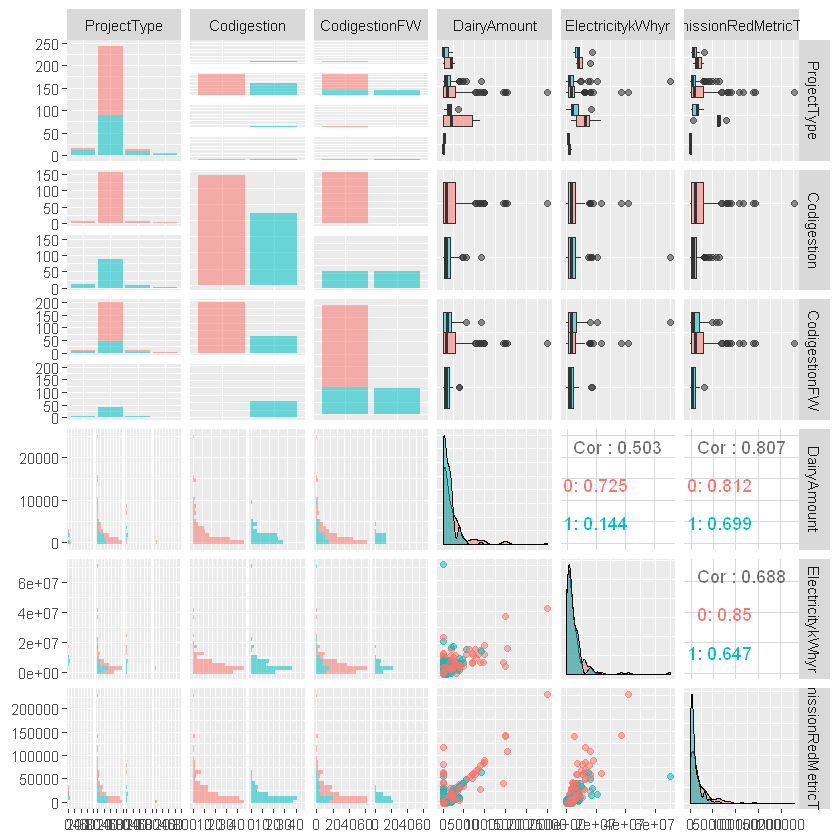

In [121]:
# Pairplot of selected variables:
ggpairs(df2[c("ProjectType","Codigestion",
             "CodigestionFW","DairyAmount",
             "ElectricitykWhyr","EmissionRedMetricTpy")], aes(colour = Codigestion, alpha = 0.4))

## 2. Machine learning

In [ ]:
# Set caret theme
trellis.par.set(caretTheme())

In [122]:
# We will use repeated cross-validation
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           repeats = 10)

### Random forest model

In [123]:
# We first train a random forest model
set.seed(0)
rf_mod <- train(ElectricitykWhyr ~ ., data = df2[-14], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [124]:
# Model performance summary
rf_mod

Random Forest 

280 samples
 12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 252, 252, 252, 252, 252, 252, ... 
Resampling results across tuning parameters:

  mtry  RMSE     Rsquared   MAE    
   2    5012905  0.3919621  3040719
   5    4546456  0.4911846  2527902
   8    4409953  0.5209924  2332441
  11    4393514  0.5285925  2268343
  14    4419458  0.5296697  2256993
  17    4480057  0.5244342  2281265
  20    4539995  0.5200308  2305509
  24    4625916  0.5128348  2337931

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 11.

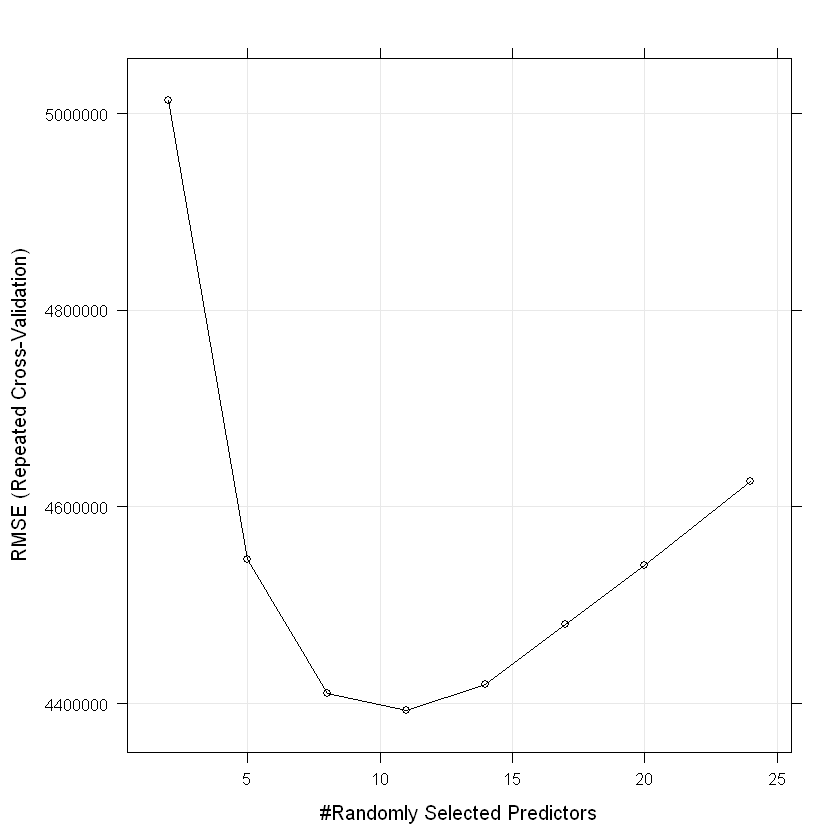

In [125]:
# Plot model training resutls
plot(rf_mod)

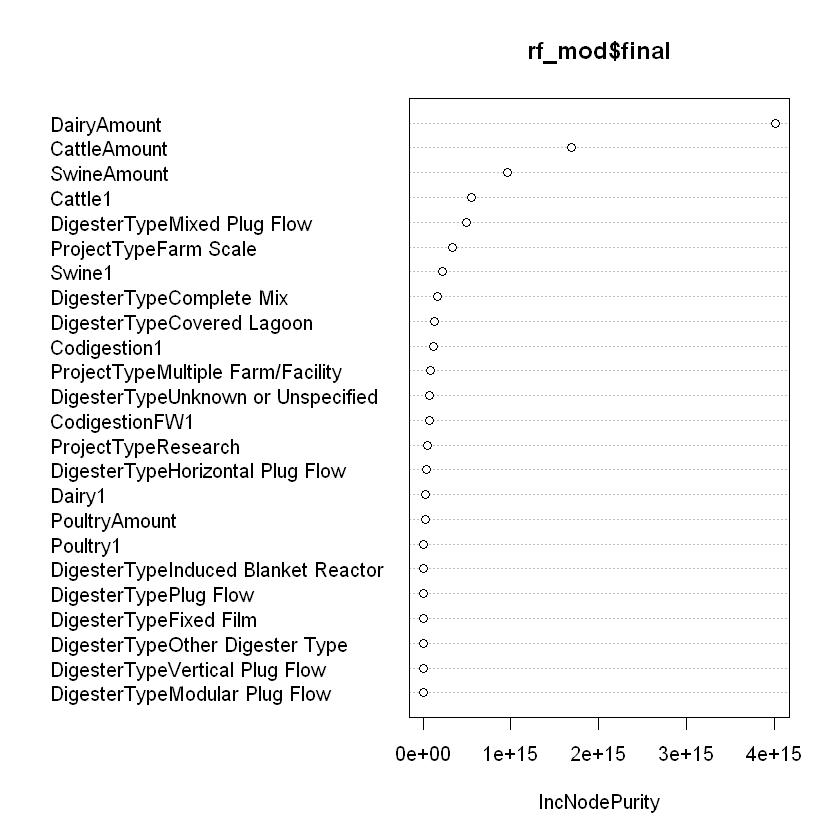

In [126]:
# Variable importance plot
varImpPlot(rf_mod$final)

### Gradient boosted machine model

In [127]:
# We first train a random forest model
set.seed(0)
gbm_mod <- train(ElectricitykWhyr ~ ., data = df2[-14], 
                 method = "gbm", 
                 trControl = fitControl,
                 tuneLength = 8)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41889436821871.8359             nan     0.1000 1513529948024.7393
     2 40600747141503.3125             nan     0.1000 1004691566494.3478
     3 39180814295790.9375             nan     0.1000 814022557251.5554
     4 38501623764156.6953             nan     0.1000 724252291520.6902
     5 37988237283174.4766             nan     0.1000 384809852673.4738
     6 37654575871294.6641             nan     0.1000 104875637452.1196
     7 36975912289132.2188             nan     0.1000 507836472189.4293
     8 36558826589015.5078             nan     0.1000 391046100389.2501
     9 36063342088168.9609             nan     0.1000 224395198115.9158
    10 35589403311371.0547             nan     0.1000 166205717369.5801
    20 33022499494937.1445             nan     0.1000 124426284157.2702
    40 30456658163697.7344             nan     0.1000 -97299023903.2815
    60 29574825359937.2656             nan     0.1000 -40191992587.6836
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37502186656141.8047             nan     0.1000 1114725313498.6221
     2 36393693081769.2969             nan     0.1000 625887315183.7146
     3 35773552513848.9688             nan     0.1000 696251404713.3905
     4 35166422580394.2031             nan     0.1000 565115026782.3422
     5 34443659192335.9375             nan     0.1000 506480309658.6704
     6 33898861706895.7812             nan     0.1000 101509631784.6056
     7 33408999751157.1641             nan     0.1000 283608966936.9247
     8 32883380977234.1719             nan     0.1000 264882839204.1719
     9 32554554909823.7891             nan     0.1000 252106691707.6467
    10 32205035527658.3242             nan     0.1000 30807028233.5549
    20 30224100840780.5312             nan     0.1000 21779091646.8480
    40 27946070715463.0859             nan     0.1000 24295935628.9943
    60 27144688395097.8477             nan     0.1000 -154969245602.6510
    80 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36851104306495.6953             nan     0.1000 1244864102475.0603
     2 35844669317241.4609             nan     0.1000 859554326907.8761
     3 34987701105223.5391             nan     0.1000 863127597809.0829
     4 33874915339876.4336             nan     0.1000 606514322310.2247
     5 33198597491935.0117             nan     0.1000 427725136918.7962
     6 32775156334077.0430             nan     0.1000 391571403163.3442
     7 32294495563206.8828             nan     0.1000 262254140692.6145
     8 31628716649442.0234             nan     0.1000 416954822121.3820
     9 31132208269704.8711             nan     0.1000 276235660748.8745
    10 30906720133592.9844             nan     0.1000 -108406483396.7294
    20 28027629729519.6758             nan     0.1000 -89490953659.6239
    40 25320685855479.5430             nan     0.1000 -18334293192.9991
    60 23961458785615.1836             nan     0.1000 -130476454395.2078
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36968186672879.3125             nan     0.1000 1093736279607.7842
     2 35827861783558.0312             nan     0.1000 851951339834.8600
     3 34574034839014.0586             nan     0.1000 -208659872027.3164
     4 33451456050684.8242             nan     0.1000 461192715488.7780
     5 32434805874426.1211             nan     0.1000 582561822096.9576
     6 31494271170512.2188             nan     0.1000 503969483310.5633
     7 30790335738629.5469             nan     0.1000 331936175018.1414
     8 30252510103565.4961             nan     0.1000 287287868236.9064
     9 29947503904131.4258             nan     0.1000 88257727929.1501
    10 29435728571666.1992             nan     0.1000 158725513573.3492
    20 26460582608745.7852             nan     0.1000 -96457626680.0216
    40 24305491107133.5430             nan     0.1000 -187243939950.6915
    60 23323152333488.5039             nan     0.1000 -189180929065.7871
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37182872878101.8125             nan     0.1000 1472614789466.2129
     2 35973633625259.1719             nan     0.1000 707991394736.2791
     3 34306397657816.7930             nan     0.1000 663576872216.4204
     4 32944732470045.8672             nan     0.1000 735345806807.0681
     5 32150266167826.4297             nan     0.1000 650383610084.7368
     6 31397218116137.4570             nan     0.1000 515307726599.1245
     7 30991480671106.3555             nan     0.1000 259612978108.8410
     8 30361173501006.9609             nan     0.1000 -53410597755.6972
     9 29758907504050.7109             nan     0.1000 274817992220.4125
    10 29380705609179.4336             nan     0.1000 92273464777.9429
    20 26093015604932.8516             nan     0.1000 -63783879992.0702
    40 23045674501046.3555             nan     0.1000 -134768359988.1338
    60 21641923295445.7617             nan     0.1000 -172893383975.9148
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36566414630892.5156             nan     0.1000 1510944603183.5120
     2 34884354005307.4609             nan     0.1000 1344965540073.8813
     3 33695999488547.7812             nan     0.1000 665817108086.2769
     4 32944705837645.5820             nan     0.1000 667239965997.8141
     5 32229850683995.6719             nan     0.1000 598454580977.5992
     6 31441008391856.7969             nan     0.1000 42307029845.7700
     7 30590252395695.5273             nan     0.1000 284669972561.9364
     8 29741566366926.6680             nan     0.1000 331255984389.6341
     9 29439657944025.7109             nan     0.1000 257238603634.1494
    10 28856034597906.5156             nan     0.1000 183046074781.6529
    20 25852128551020.0742             nan     0.1000 -146485483796.7558
    40 24250419196485.0469             nan     0.1000 -375224628025.9725
    60 23380147007791.3594             nan     0.1000 -309118919369.6572
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37021803050342.5781             nan     0.1000 1095793629367.7839
     2 35522567533586.5391             nan     0.1000 1070534910679.5367
     3 34002105286561.8555             nan     0.1000 989847547158.0947
     4 33197326444055.1055             nan     0.1000 684608860690.1637
     5 32187301496910.0938             nan     0.1000 395175565453.6433
     6 31468450668517.5508             nan     0.1000 523127022717.4329
     7 30703019227391.7852             nan     0.1000 505369297130.2183
     8 30228923707992.9531             nan     0.1000 194867404030.6143
     9 29503166562647.7305             nan     0.1000 -15744467946.5834
    10 28938055366779.7031             nan     0.1000 67514360252.1329
    20 26330226043306.9688             nan     0.1000 -106656513223.1997
    40 24307201012127.1875             nan     0.1000 -162428954050.6079
    60 22838179609137.9102             nan     0.1000 -112031732176.5268
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36752024336491.4531             nan     0.1000 1555343239133.4680
     2 35581647860424.2891             nan     0.1000 982068600452.9205
     3 34281905426291.6641             nan     0.1000 479503250969.7710
     4 33156407019982.9844             nan     0.1000 781912980706.7639
     5 32131751440528.9570             nan     0.1000 654534693324.0381
     6 31420618545673.0078             nan     0.1000 520214041051.7721
     7 30697502862874.0195             nan     0.1000 313121392000.2009
     8 29910713657581.6016             nan     0.1000 300286162609.3705
     9 29295532388550.5078             nan     0.1000 437894729277.2672
    10 28945706463903.5703             nan     0.1000 113311052419.4401
    20 26277847272806.4805             nan     0.1000 -218312828115.1919
    40 24398445525862.2969             nan     0.1000 -96706213731.4954
    60 22181235675613.3477             nan     0.1000 -277352289255.0717
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36679713206371.8359             nan     0.1000 1202506695689.4248
     2 35434156857852.1641             nan     0.1000 958954921307.2040
     3 34093264480854.9492             nan     0.1000 732814712338.3761
     4 33012931622922.1836             nan     0.1000 1116771521043.2095
     5 32171948412369.3867             nan     0.1000 326315016573.9705
     6 31416766846789.4219             nan     0.1000 231786752150.3380
     7 30736690580528.9805             nan     0.1000 547738250005.8158
     8 30354326419288.8828             nan     0.1000 287884563129.3946
     9 29902033155455.5703             nan     0.1000 349947674427.9370
    10 29074094394484.1797             nan     0.1000 309768237359.8558
    20 25897572710397.2695             nan     0.1000 -120665539532.7325
    40 23826569567747.7070             nan     0.1000 -138851232752.1066
    60 22037846558620.7656             nan     0.1000 -235907965430.9239
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25883722594963.4766             nan     0.1000 1593218937570.3904
     2 24327343562822.6992             nan     0.1000 1415655475751.0742
     3 22770489489651.2773             nan     0.1000 1200144723039.9338
     4 21729284185264.5625             nan     0.1000 353474706091.5245
     5 21004131961480.2188             nan     0.1000 592722716767.0132
     6 20508152918932.0078             nan     0.1000 423817477873.4915
     7 19636503495498.3828             nan     0.1000 81925048073.9830
     8 19193374103180.3203             nan     0.1000 115578624655.2710
     9 18708211861492.3125             nan     0.1000 355344874760.1478
    10 18236386330206.8047             nan     0.1000 382093964349.3567
    20 15952952923721.7891             nan     0.1000 163336784665.5118
    40 13965993274476.2344             nan     0.1000 -122160356476.2784
    60 13199843168475.5605             nan     0.1000 -118969835759.9015
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25453324657824.1875             nan     0.1000 1955424555236.1213
     2 24454850813467.6211             nan     0.1000 1205336995075.2527
     3 23040105577865.1797             nan     0.1000 1331861320471.8323
     4 22146554173415.9961             nan     0.1000 780683508486.0933
     5 20699508426190.0352             nan     0.1000 713939091752.4895
     6 20100396095307.2344             nan     0.1000 659970736386.3798
     7 19251252147951.7930             nan     0.1000 951749030698.3282
     8 18733008039693.0859             nan     0.1000 470852093257.3369
     9 18049022677350.4258             nan     0.1000 801702185676.5837
    10 17592508581929.8477             nan     0.1000 399640010533.7268
    20 14467715249422.4121             nan     0.1000 113766226687.4863
    40 12700326515963.6699             nan     0.1000 47373098439.7035
    60 12080948666698.9629             nan     0.1000 -54396292852.8810
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25582110494834.5273             nan     0.1000 1616458640613.9966
     2 23517629474290.5820             nan     0.1000 1615821272730.3889
     3 21577660217985.4766             nan     0.1000 1208539301051.3789
     4 20117702874558.0312             nan     0.1000 1309160217830.7502
     5 19403307280959.3086             nan     0.1000 629289734037.1494
     6 18478536330701.1562             nan     0.1000 810777511221.0040
     7 17837218779565.8672             nan     0.1000 526611339460.6194
     8 17063741368190.7539             nan     0.1000 617764363851.0524
     9 16606887741993.3555             nan     0.1000 387701608439.4303
    10 16105136927751.7930             nan     0.1000 315598074879.6877
    20 13859771313468.0859             nan     0.1000 -47381305010.1509
    40 11761662383922.4453             nan     0.1000 2114315885.3152
    60 11175135403320.2891             nan     0.1000 -2432821849.3878
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25626602459495.9297             nan     0.1000 1873767403277.8291
     2 23778848376849.0859             nan     0.1000 1670757490751.9717
     3 22162553512140.4219             nan     0.1000 1394165687140.6570
     4 20865090396392.4844             nan     0.1000 1414377331337.1104
     5 19612162960850.5156             nan     0.1000 874362044397.5027
     6 18723230521019.0195             nan     0.1000 812253359047.3782
     7 18031659019300.0156             nan     0.1000 287770944775.0411
     8 17562326824275.2578             nan     0.1000 537745636859.9659
     9 17220529209213.6523             nan     0.1000 262931408835.2865
    10 16745093994125.3281             nan     0.1000 499519148307.2831
    20 13916516501101.5762             nan     0.1000 -31027793889.5019
    40 12052063829850.7559             nan     0.1000 -126825684262.2928
    60 10891030836186.9336             nan     0.1000 -34159265179.7228
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 24948202568226.9531             nan     0.1000 1955652984617.3428
     2 23261864598535.1133             nan     0.1000 1873929831814.6804
     3 21234151060174.8164             nan     0.1000 1435781636890.6387
     4 19978730047459.3594             nan     0.1000 1047856301708.0187
     5 18552571878979.2227             nan     0.1000 866373769415.9875
     6 17925557416333.8945             nan     0.1000 506445351438.1075
     7 17124124152607.1602             nan     0.1000 569051192218.1614
     8 16226166710243.9160             nan     0.1000 570145748347.3125
     9 15578421165026.3438             nan     0.1000 246305610735.7388
    10 15186854945253.4141             nan     0.1000 234217172980.3735
    20 12835021354975.0312             nan     0.1000 26062039482.2891
    40 11379993196235.5098             nan     0.1000 -47184177820.4644
    60 10527593766775.7891             nan     0.1000 -103056192030.1888
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25217732787717.0820             nan     0.1000 2556174967457.4526
     2 23001605347844.2617             nan     0.1000 1682946276337.2512
     3 21235389449258.9961             nan     0.1000 1064657187715.0404
     4 20218364667959.6562             nan     0.1000 1128305635172.0867
     5 18893109589177.4492             nan     0.1000 978421421111.0480
     6 17832621825451.4062             nan     0.1000 897806464966.8470
     7 17062065303332.1680             nan     0.1000 553344627147.6489
     8 16366855800680.1504             nan     0.1000 639171564230.9749
     9 15900840223700.3457             nan     0.1000 364541313427.0916
    10 15477975029287.7734             nan     0.1000 324034753265.1488
    20 12973423831747.6270             nan     0.1000 126296274301.0333
    40 11114208488632.8672             nan     0.1000 -183316145236.6294
    60 10145988709828.0156             nan     0.1000 -229848375525.7395


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 24422794896910.0703             nan     0.1000 2005405996026.3271
     2 22645649463872.0000             nan     0.1000 1433968641962.9478
     3 21008414484956.3789             nan     0.1000 1397392186808.8452
     4 19679312262470.3438             nan     0.1000 1119775590083.9514
     5 18806699734415.2617             nan     0.1000 858460817401.0676
     6 17763334635606.8711             nan     0.1000 609280195751.0797
     7 17252446643107.2051             nan     0.1000 465444032504.4083
     8 16596313139181.8027             nan     0.1000 491851835616.6689
     9 15874094162376.6934             nan     0.1000 76624126078.2196
    10 15376504427119.7871             nan     0.1000 354892688814.6628
    20 12875587530526.1289             nan     0.1000 -113561495118.6226
    40 11099654675454.2832             nan     0.1000 -145821701845.8385
    60 10138442825034.3555             nan     0.1000 -110395665493.6346


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25275971733444.3984             nan     0.1000 1788480874452.6743
     2 23156862497512.7734             nan     0.1000 1744066814465.4058
     3 21941179479352.7617             nan     0.1000 1459313728516.6477
     4 20974459162757.7734             nan     0.1000 903093694644.8401
     5 19892349221226.0039             nan     0.1000 1170500162965.0837
     6 18822082817068.5000             nan     0.1000 1004287171804.5311
     7 18285739999083.4492             nan     0.1000 446802998521.8165
     8 17556329780043.7500             nan     0.1000 710422846103.3716
     9 16852180014831.9512             nan     0.1000 633389537558.3070
    10 15929108186889.5684             nan     0.1000 157406493103.3277
    20 12989627530816.6270             nan     0.1000 -90611993202.3308
    40 10946254863961.4492             nan     0.1000 -288536022436.4136
    60 9933187775911.5254             nan     0.1000 -46481314127.3710
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36378175173013.7891             nan     0.1000 887241964854.1277
     2 35704698019166.3203             nan     0.1000 752055116988.5569
     3 35051562057201.5977             nan     0.1000 733060622671.1522
     4 34569407002360.8047             nan     0.1000 182042516440.1946
     5 33683510496365.0820             nan     0.1000 566809798955.3074
     6 33164663905089.8008             nan     0.1000 500135832373.6747
     7 32580027837356.8516             nan     0.1000 371594398078.9488
     8 32217721685793.6133             nan     0.1000 310867692987.3271
     9 31990440603315.1328             nan     0.1000 197804972133.1087
    10 31614873345838.3008             nan     0.1000 148461657262.4324
    20 29601687717010.2383             nan     0.1000 -107118278808.9804
    40 27314363790929.5234             nan     0.1000 -95653711710.1305
    60 26299946308172.1875             nan     0.1000 -26710178961.5760
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36345191251596.9688             nan     0.1000 963111012496.0371
     2 34902144929577.3867             nan     0.1000 1096957794149.2743
     3 33843191819027.0703             nan     0.1000 830971527819.7957
     4 33201286576287.6172             nan     0.1000 377281487011.2056
     5 32498034105980.4492             nan     0.1000 478771810137.9347
     6 31846639007244.4258             nan     0.1000 475599830568.3386
     7 31250457733112.8398             nan     0.1000 149567356510.6941
     8 30650813158848.0859             nan     0.1000 435771797124.1870
     9 30426169401891.8516             nan     0.1000 102038863235.1681
    10 30060564707381.0938             nan     0.1000 -186459951674.9940
    20 27037402431143.3359             nan     0.1000 18242819429.5668
    40 24799922063877.2734             nan     0.1000 -162841327389.5527
    60 23403009520781.6719             nan     0.1000 -147171108359.6745
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 35831430495840.0703             nan     0.1000 1406856464468.9163
     2 34575054986874.1992             nan     0.1000 1031920378326.2142
     3 33741577699749.3320             nan     0.1000 716729489353.7158
     4 32927668506904.9180             nan     0.1000 436079532996.1179
     5 31814649207471.2188             nan     0.1000 585893974613.1532
     6 31007955064499.2188             nan     0.1000 270788671095.9781
     7 30233886340215.7422             nan     0.1000 78682041244.0104
     8 29844259322140.3164             nan     0.1000 76332009904.2254
     9 29403789687359.4492             nan     0.1000 116076567889.3480
    10 28754800768091.6211             nan     0.1000 224425564270.3966
    20 26138660638142.6523             nan     0.1000 -149721574772.1593
    40 24139703571628.4531             nan     0.1000 -140538375909.9306
    60 22405907514503.7891             nan     0.1000 -151887618700.3064
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36213210654234.2891             nan     0.1000 1453653295994.9797
     2 34594633562532.4062             nan     0.1000 1087402746577.4272
     3 33482513154606.1367             nan     0.1000 1054523789301.7415
     4 32286143316024.8281             nan     0.1000 671426173326.8064
     5 31593761048981.0703             nan     0.1000 605067180248.1241
     6 31272606329531.1523             nan     0.1000 184665127400.1162
     7 30521598157519.3164             nan     0.1000 535601699554.3026
     8 29953157175479.3945             nan     0.1000 218802244419.0155
     9 29298453679238.3789             nan     0.1000 121832605288.9531
    10 28843425094357.8555             nan     0.1000 -19494048533.7375
    20 26530926487299.2852             nan     0.1000 -18135608935.0346
    40 24552252595662.5586             nan     0.1000 -187785568613.4519
    60 22621575336648.8555             nan     0.1000 -367045471551.0005
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36253599641862.6875             nan     0.1000 1574596327226.8923
     2 34612052552342.8125             nan     0.1000 1247119159138.4824
     3 33349193190484.1875             nan     0.1000 1028319759111.6689
     4 32891170121675.4180             nan     0.1000 48413385847.7126
     5 31764947752362.2383             nan     0.1000 732558539198.2003
     6 31035348713540.0312             nan     0.1000 537492431324.7921
     7 30461507831188.3047             nan     0.1000 485256297747.5031
     8 29748778588820.2188             nan     0.1000 397263823411.8663
     9 29327505813876.0664             nan     0.1000 146370281936.3969
    10 28862378524390.8359             nan     0.1000 144571227540.9065
    20 25440280913367.9961             nan     0.1000 -131896863440.4046
    40 22413412985108.3711             nan     0.1000 -175666323473.4058
    60 21036678923708.0000             nan     0.1000 -262149710054.3689
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 35792661463947.3594             nan     0.1000 1612526269860.5803
     2 34322783171543.7930             nan     0.1000 1238847419253.2058
     3 33505019360764.4609             nan     0.1000 896007430507.9111
     4 32311048524527.1289             nan     0.1000 722647252102.3184
     5 31317733074277.4961             nan     0.1000 739987360513.7372
     6 30734894463872.1094             nan     0.1000 523694248696.3337
     7 29742281535812.1602             nan     0.1000 329407426869.2858
     8 29336744530965.1367             nan     0.1000 378282758935.9160
     9 28651127769973.1562             nan     0.1000 315426868198.7853
    10 28052002005338.8789             nan     0.1000 579508173.1642
    20 25709481042429.0195             nan     0.1000 -192253797114.8025
    40 23529560705940.8281             nan     0.1000 -266620939111.3625
    60 22125416715769.0898             nan     0.1000 -162476769360.7222
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36184544589188.4766             nan     0.1000 1483773312002.6851
     2 34405877222944.4414             nan     0.1000 1070318575148.1636
     3 33026800133372.6367             nan     0.1000 745889583384.8029
     4 31899155108869.8281             nan     0.1000 594474065448.8889
     5 31192312338446.4883             nan     0.1000 672861250648.5321
     6 30504563576745.5117             nan     0.1000 592778666071.0084
     7 29842736564451.4023             nan     0.1000 542281916847.4406
     8 29299569056111.2070             nan     0.1000 95932602793.5516
     9 28679683355902.4336             nan     0.1000 221548073643.0609
    10 28458042442424.2773             nan     0.1000 -206694658761.3528
    20 25507735255762.6914             nan     0.1000 -132766527050.7221
    40 22477736286187.1211             nan     0.1000 -103911885186.7256
    60 22185233604847.5977             nan     0.1000 -221413678279.2228
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 35823451119659.0156             nan     0.1000 1400076861912.5378
     2 34689687434178.0039             nan     0.1000 996612776003.1587
     3 33074061784165.6562             nan     0.1000 825857924676.1208
     4 31991804520756.2773             nan     0.1000 694408573812.4762
     5 31184573320671.7383             nan     0.1000 634832610679.5878
     6 30158378732455.6719             nan     0.1000 525074342956.7100
     7 29585655577898.7422             nan     0.1000 357006037177.1111
     8 28863567367463.0156             nan     0.1000 367893073273.9866
     9 28487931435082.4844             nan     0.1000 -22108219274.2130
    10 28053381053801.9727             nan     0.1000 26468524868.9521
    20 24652505165731.3867             nan     0.1000 -54421002984.3971
    40 22250768794136.3828             nan     0.1000 -204942985266.9349
    60 20473343471156.8047             nan     0.1000 -136404716482.0691
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42064385432648.4141             nan     0.1000 1185049442341.9495
     2 40844766182045.9531             nan     0.1000 489543551457.6505
     3 39954134723883.6328             nan     0.1000 679347486192.4637
     4 39455641620412.3203             nan     0.1000 372829594759.4913
     5 38376886781383.9375             nan     0.1000 456950392060.5346
     6 38054954880392.1641             nan     0.1000 299996591038.8013
     7 37301481337134.0000             nan     0.1000 336787875883.3231
     8 37183444855299.1172             nan     0.1000 -252009852262.4909
     9 36610301382047.9219             nan     0.1000 246966441734.0614
    10 36158951687247.3125             nan     0.1000 150543318252.3144
    20 33452715125113.9219             nan     0.1000 71326804014.0480
    40 31108978449271.6992             nan     0.1000 -126007597447.5952
    60 30175322048871.5039             nan     0.1000 -246128202439.8610
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42656737444428.2812             nan     0.1000 1023631135201.1290
     2 41329886093997.1016             nan     0.1000 1271087311009.7290
     3 40113823416587.3828             nan     0.1000 1075298363217.5410
     4 39245974478478.7656             nan     0.1000 925680877146.9226
     5 38638361916084.9844             nan     0.1000 569601827054.5469
     6 37436273833333.1953             nan     0.1000 717186495218.2551
     7 36584766063362.0156             nan     0.1000 556937373311.4498
     8 36121877520788.9688             nan     0.1000 484269673063.4726
     9 35803935488939.4375             nan     0.1000 167302056663.1604
    10 35113904122139.9023             nan     0.1000 406487316261.2433
    20 31706229205733.8008             nan     0.1000 -86862272019.8987
    40 28648818084091.0117             nan     0.1000 -83663012958.9491
    60 27139346441925.5625             nan     0.1000 -231270186510.7686
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41946938164730.0000             nan     0.1000 1713495676063.2637
     2 40143587934686.6016             nan     0.1000 652467295076.2938
     3 38908666971390.2734             nan     0.1000 968900455996.2014
     4 38370373174407.8047             nan     0.1000 437788314609.0621
     5 37314972520994.1641             nan     0.1000 1065647269745.7842
     6 36356755165292.5547             nan     0.1000 318390708215.8217
     7 35264877621071.1328             nan     0.1000 803561710291.4885
     8 34552554555390.0938             nan     0.1000 159898227387.2016
     9 33927307018137.8633             nan     0.1000 466007647150.3580
    10 33381445758057.3164             nan     0.1000 343717482314.3408
    20 30141173221337.1016             nan     0.1000 -116066583342.3356
    40 27495416881125.6875             nan     0.1000 -522132564960.3802
    60 26308034895646.3008             nan     0.1000 -172188677791.0612
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42185233675731.2422             nan     0.1000 1514664205922.8613
     2 39954184342238.5547             nan     0.1000 1377991313455.0466
     3 38331671529676.2656             nan     0.1000 876705898316.5332
     4 37225712752113.5859             nan     0.1000 1149288228459.6960
     5 36114770632695.7891             nan     0.1000 890825937586.4624
     6 35082052645653.1797             nan     0.1000 703359426505.7230
     7 34107164766843.6914             nan     0.1000 -16216626290.4409
     8 33262701655683.0547             nan     0.1000 399733925115.3015
     9 32778669296904.6641             nan     0.1000 171886380822.3314
    10 32311849164014.1406             nan     0.1000 273082120547.2714
    20 29502280660938.7109             nan     0.1000 -198394419499.9792
    40 27153416421054.3945             nan     0.1000 -40531630944.8805
    60 24949675461035.3594             nan     0.1000 -141670399651.8095
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41415028587660.8750             nan     0.1000 1235516393115.0603
     2 39872781712397.8828             nan     0.1000 1198379071603.9910
     3 38467313051480.6172             nan     0.1000 876035029131.6682
     4 37338945403175.3750             nan     0.1000 1170396846749.7915
     5 35966555407766.4141             nan     0.1000 588572353487.5393
     6 35472958703203.2578             nan     0.1000 419910264183.3875
     7 34655188843866.3164             nan     0.1000 276343300429.1470
     8 34205654017162.3398             nan     0.1000 -85577730091.1373
     9 33527739437046.8789             nan     0.1000 434701392876.2047
    10 32982883901792.9180             nan     0.1000 344000459267.5587
    20 29695637271530.6523             nan     0.1000 -262230384193.2206
    40 26897780762834.8867             nan     0.1000 -170032123462.4553
    60 24668202845159.4180             nan     0.1000 -105388018958.0685


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41900306943117.1328             nan     0.1000 1732575450826.1428
     2 40546103151341.1953             nan     0.1000 1001676858513.9218
     3 39086735528058.6875             nan     0.1000 847487817049.0994
     4 37650594891671.5234             nan     0.1000 1276773984049.6980
     5 36522323245836.1797             nan     0.1000 796041323831.1777
     6 35774224444530.5469             nan     0.1000 537086670738.1899
     7 34671186642301.4805             nan     0.1000 402255044521.2008
     8 34129980221278.6289             nan     0.1000 617537369160.7494
     9 33789154560480.3516             nan     0.1000 302370900708.3174
    10 33017619599976.5312             nan     0.1000 145101105108.3519
    20 28503561952548.0312             nan     0.1000 149390302990.1700
    40 25303485156949.3438             nan     0.1000 -327016478535.9103
    60 23152422911131.3828             nan     0.1000 -157804468553.5309
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42387887930221.6172             nan     0.1000 1078749594904.2327
     2 40295460100663.7969             nan     0.1000 1794096610316.7275
     3 38872039318301.2344             nan     0.1000 1390684190931.8179
     4 37287513182848.0234             nan     0.1000 290460349024.8835
     5 36642368875047.9531             nan     0.1000 75820953728.0589
     6 35461762475972.6484             nan     0.1000 1028531820778.3917
     7 34838394212534.5586             nan     0.1000 -211962385635.2796
     8 34257992568335.7891             nan     0.1000 387017803085.8519
     9 33431226946246.5234             nan     0.1000 701493846123.9602
    10 32855548931472.1445             nan     0.1000 258122441113.3994
    20 28819327755103.4336             nan     0.1000 -254400111054.1475
    40 25501078339479.6133             nan     0.1000 -313644051049.8138
    60 23883868231490.0039             nan     0.1000 -112498751814.2164

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41685850784148.0938             nan     0.1000 1849017258344.5681
     2 39684622043176.7969             nan     0.1000 1156462722013.3318
     3 38155295514515.7734             nan     0.1000 919940111458.7526
     4 37498321887894.3438             nan     0.1000 588460842649.5261
     5 36075148439985.2969             nan     0.1000 699890874254.1881
     6 34726024682300.1016             nan     0.1000 -56005778461.8126
     7 33828639065948.9961             nan     0.1000 448878157324.7120
     8 32835743419649.3516             nan     0.1000 561139371696.7827
     9 32412489978083.0273             nan     0.1000 455216768546.4244
    10 31776168414552.6484             nan     0.1000 195814896444.9731
    20 28550924469983.8906             nan     0.1000 -116049326626.6618
    40 25360580022993.1289             nan     0.1000 -66944746262.6191
    60 23103679545275.0039             nan     0.1000 -229866859513.7993
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42278588023009.9844             nan     0.1000 1520628478535.3467
     2 41122450501409.1484             nan     0.1000 1267021502901.4080
     3 39964264122331.5859             nan     0.1000 1020967942098.9254
     4 39349096932223.0469             nan     0.1000 639547829820.8888
     5 38680604267502.4844             nan     0.1000 251165229287.7449
     6 38460365118433.0312             nan     0.1000 -247136918403.4001
     7 37737623214153.6406             nan     0.1000 607019986895.0144
     8 37258523530110.5547             nan     0.1000 223091806731.9182
     9 36859459177046.9219             nan     0.1000 411740610044.9876
    10 36530409785959.9844             nan     0.1000 177163209570.9255
    20 33353463017958.8828             nan     0.1000 -121317708707.2387
    40 30585540619703.0352             nan     0.1000 -105851433437.0419
    60 29420531098304.0234             nan     0.1000 -53987716730.7548


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41658636231231.5859             nan     0.1000 1555787010803.1394
     2 40042846591271.7109             nan     0.1000 225088813970.1825
     3 38957559611835.8750             nan     0.1000 933156110635.8199
     4 37760137976593.9531             nan     0.1000 861063091362.7224
     5 36936164898094.1328             nan     0.1000 598594924794.8723
     6 36083464806310.8672             nan     0.1000 527684597357.5623
     7 35343188424033.8750             nan     0.1000 444618409658.9675
     8 34611648478925.6016             nan     0.1000 61195490828.5250
     9 34257996903344.3047             nan     0.1000 238931926445.4781
    10 33909928028269.8359             nan     0.1000 78382242754.5214
    20 30834292230180.6484             nan     0.1000 1960623982.6242
    40 28378459958384.8047             nan     0.1000 -371048099811.3892
    60 26422756876377.6016             nan     0.1000 -262173867528.9138
    80 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41435248017038.5859             nan     0.1000 1817944351874.1174
     2 39651510010150.4141             nan     0.1000 1085487062753.1063
     3 38373200631556.5312             nan     0.1000 1090722303298.5911
     4 37543901304551.5391             nan     0.1000 303082350429.1064
     5 36098518694190.2344             nan     0.1000 639154347916.0708
     6 35371529895466.3750             nan     0.1000 711565347232.3672
     7 34936686257724.0352             nan     0.1000 329002799934.2138
     8 34001132562675.1211             nan     0.1000 293349740166.3871
     9 33223761334910.4414             nan     0.1000 114130993495.8156
    10 32573128928578.4805             nan     0.1000 382504750438.4564
    20 29698367337695.7148             nan     0.1000 -434060332238.6633
    40 27073504768507.3438             nan     0.1000 -126737997824.7535
    60 25605279585023.0508             nan     0.1000 -118177627753.8580


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40853979097859.1094             nan     0.1000 1440133285522.2336
     2 39687116023949.7266             nan     0.1000 1233149690308.8674
     3 38079532600016.6875             nan     0.1000 1414572432918.4119
     4 37271570468595.2266             nan     0.1000 429382506718.7450
     5 35868221039358.7109             nan     0.1000 536859957327.4653
     6 34662096576365.8594             nan     0.1000 437764224123.5317
     7 34067835433067.6914             nan     0.1000 478163832566.1616
     8 33627976613949.3203             nan     0.1000 102017063171.9102
     9 33302275984833.9727             nan     0.1000 19459099500.8836
    10 33090886961682.5312             nan     0.1000 27532394506.0099
    20 30191044931234.5273             nan     0.1000 -169688512528.1907
    40 27917774075369.1641             nan     0.1000 -211960612082.9489
    60 26305114837259.8945             nan     0.1000 -50780028913.2679
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42481563002615.1016             nan     0.1000 943196011849.6106
     2 40864621681139.4453             nan     0.1000 1731611360863.4221
     3 39055045812308.5781             nan     0.1000 1139727049099.3071
     4 37436982599241.0000             nan     0.1000 1601882781408.2869
     5 36327804991294.3828             nan     0.1000 873898240586.3834
     6 35749138940410.5000             nan     0.1000 240296221752.5091
     7 35156135341331.2812             nan     0.1000 592918029650.2883
     8 34226072238284.6602             nan     0.1000 568247366007.5375
     9 33620696876291.4805             nan     0.1000 635266696479.2355
    10 33208822639892.1562             nan     0.1000 416108257532.7256
    20 29926257375961.4141             nan     0.1000 -15371579446.9356
    40 26719405114773.0742             nan     0.1000 -111259604238.9264
    60 24279282504111.8047             nan     0.1000 -111157705418.3829
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41899781253611.3984             nan     0.1000 1938657886278.1726
     2 39625757669345.0703             nan     0.1000 1154949240780.6096
     3 38524565516179.1797             nan     0.1000 1128515781088.5430
     4 37200590454443.0703             nan     0.1000 1067025096842.3140
     5 36043108781792.9688             nan     0.1000 910874953887.4757
     6 35213551575957.2109             nan     0.1000 779110927816.7089
     7 34507445906850.8828             nan     0.1000 718453225590.4701
     8 33291490810598.4727             nan     0.1000 322696435589.4202
     9 32546008619025.9805             nan     0.1000 413320812574.3685
    10 32198019337006.6797             nan     0.1000 142796251735.9131
    20 27694427830691.7109             nan     0.1000 -273868553698.4656
    40 25150250715307.4727             nan     0.1000 -374315647423.9192
    60 23041517638030.9883             nan     0.1000 -270283637449.5906

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41081319880056.8828             nan     0.1000 1864367318991.2393
     2 39294303879385.9609             nan     0.1000 1462106119631.2949
     3 37959286078625.7578             nan     0.1000 1117664075339.5662
     4 36449238995133.2188             nan     0.1000 1131498592208.0432
     5 35630605180247.0391             nan     0.1000 -8126844006.2031
     6 34188663216623.5547             nan     0.1000 945971235280.6451
     7 33339509603077.7617             nan     0.1000 476029183512.2115
     8 32665823708598.2930             nan     0.1000 557566866891.5222
     9 32214357735016.0195             nan     0.1000 407207051339.1219
    10 31782434706553.9180             nan     0.1000 114079677649.8347
    20 28369752088922.5859             nan     0.1000 -22821410034.9490
    40 25539293457944.0586             nan     0.1000 -59879602199.6749
    60 23780246154400.0820             nan     0.1000 -327717002275.7308
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41519733200504.2734             nan     0.1000 1349977562145.5269
     2 39665714903186.8047             nan     0.1000 1504594241894.1536
     3 37771847997180.6094             nan     0.1000 1068384571161.2534
     4 36753725980644.8125             nan     0.1000 537066266206.7060
     5 35710746015678.9141             nan     0.1000 862229107214.3229
     6 35077860868832.0703             nan     0.1000 326000304986.1982
     7 33563837222790.3477             nan     0.1000 525618320606.8594
     8 32806686177283.7461             nan     0.1000 191881085873.5822
     9 32322040635218.0273             nan     0.1000 233641425261.5316
    10 31560394674033.1484             nan     0.1000 245387360651.9443
    20 27675560248750.4062             nan     0.1000 -13711242478.8252
    40 24645478327961.5742             nan     0.1000 -303270815562.3815
    60 22829228657902.0391             nan     0.1000 -182296693366.3208
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41930065076870.3672             nan     0.1000 1159496608473.6448
     2 40663617306642.2812             nan     0.1000 737994408685.6385
     3 39713713209893.1875             nan     0.1000 761721623222.7998
     4 38958864065075.9219             nan     0.1000 662967386454.5920
     5 38377139850949.1562             nan     0.1000 364787110302.9912
     6 38160875462973.3281             nan     0.1000 140835162966.9596
     7 37381860248198.8984             nan     0.1000 166400921372.7290
     8 36689395754950.3594             nan     0.1000 629892586782.2202
     9 36016680965364.8906             nan     0.1000 330384060504.6565
    10 35691176238711.7188             nan     0.1000 265885707403.7155
    20 33437950966586.0352             nan     0.1000 -82933513076.6812
    40 30655426288975.5312             nan     0.1000 -50063889747.2654
    60 29638633651819.1484             nan     0.1000 -70209911820.7432
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41786871232274.6953             nan     0.1000 1495530803103.4924
     2 40329919637296.4766             nan     0.1000 1465578516481.0129
     3 39275970200268.4375             nan     0.1000 691471496775.8381
     4 38386883413948.7578             nan     0.1000 762693602757.7375
     5 37446409767430.0781             nan     0.1000 850163466903.9688
     6 36506094041398.5391             nan     0.1000 502217999293.9208
     7 35734958447261.9453             nan     0.1000 533115290981.4142
     8 35123857914820.1680             nan     0.1000 360156609947.4460
     9 34845013514170.0430             nan     0.1000 51117255146.8673
    10 34001109835773.6797             nan     0.1000 219118603950.6799
    20 30561909364068.7344             nan     0.1000 85990414581.1473
    40 27519719200877.1211             nan     0.1000 -133082747937.7403
    60 26509956536173.2461             nan     0.1000 -129250252215.2034
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41682352131420.3828             nan     0.1000 1645899382933.2715
     2 40560489707993.0469             nan     0.1000 213682133655.9071
     3 38708467180301.5859             nan     0.1000 1386044910336.7158
     4 37907666967454.8359             nan     0.1000 709111408412.3301
     5 36740292028132.0469             nan     0.1000 979862102477.7689
     6 35607563441898.2188             nan     0.1000 1006440242313.3629
     7 34525093155081.7148             nan     0.1000 122040022376.6179
     8 33784694580516.6953             nan     0.1000 551328669036.2489
     9 33014259627466.2617             nan     0.1000 55216659014.2352
    10 32426244457041.5078             nan     0.1000 359996663173.5247
    20 29616282124075.8242             nan     0.1000 18922119033.6244
    40 26965779342770.2266             nan     0.1000 -173389300475.5140
    60 25400567267828.8047             nan     0.1000 -241322074133.5572
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41086846730814.7031             nan     0.1000 1408246922207.7554
     2 39508678669640.2812             nan     0.1000 1596637962403.9722
     3 37792492660097.1094             nan     0.1000 1375042574552.7581
     4 36900157452151.5938             nan     0.1000 829310872310.3474
     5 35837468184537.3281             nan     0.1000 851476859580.8878
     6 34821950190788.7617             nan     0.1000 370902714539.9764
     7 34225381263775.2617             nan     0.1000 544800425731.9214
     8 33533453788399.2500             nan     0.1000 174751808575.6024
     9 33098907790700.1992             nan     0.1000 120644337742.5667
    10 32501066463343.2812             nan     0.1000 139206573644.4513
    20 28906187484644.4414             nan     0.1000 -133591081126.0364
    40 26552114296977.6211             nan     0.1000 -213445510296.2162
    60 24732526034868.7227             nan     0.1000 -133800426890.7552


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41466460490207.6719             nan     0.1000 2099620642533.9866
     2 39883967383162.3750             nan     0.1000 993915122544.2209
     3 39003189192855.9844             nan     0.1000 394780333942.0765
     4 37253605628078.4453             nan     0.1000 994623254141.8051
     5 36368159736163.9688             nan     0.1000 822718648992.3031
     6 34727019936494.6758             nan     0.1000 598225631133.2683
     7 33512912927048.8828             nan     0.1000 693416427279.7126
     8 32920103361165.0234             nan     0.1000 225188815993.1252
     9 32387081549083.0469             nan     0.1000 333857075396.2957
    10 31996644582726.9805             nan     0.1000 303710751204.1619
    20 28686005250943.2188             nan     0.1000 -150052568705.7912
    40 26423901278906.6484             nan     0.1000 -336029613586.9799
    60 24592249281282.2188             nan     0.1000 -167832083293.4086
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41615341185327.2578             nan     0.1000 1940569543173.0771
     2 39956096474068.5938             nan     0.1000 1450492088327.9072
     3 38577881497259.5078             nan     0.1000 857963946469.3787
     4 37636214899262.1797             nan     0.1000 1108921854257.9277
     5 36004828772668.0469             nan     0.1000 664811972529.1115
     6 35170003559921.3945             nan     0.1000 594358458681.2899
     7 34108281984707.0273             nan     0.1000 239813175164.3281
     8 33463278956192.5312             nan     0.1000 -92749942247.6599
     9 32920239504660.2852             nan     0.1000 125520283269.5715
    10 32406513705880.7266             nan     0.1000 362733310567.0773
    20 29172690491210.0664             nan     0.1000 -95315322592.4753
    40 25756853476482.4727             nan     0.1000 -41989484137.8530
    60 24080330051234.7969             nan     0.1000 -434288233099.8806
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41187044279392.9219             nan     0.1000 1892410438673.6750
     2 39666363546065.6094             nan     0.1000 1068915718061.7385
     3 38559445271555.0781             nan     0.1000 615430955204.5370
     4 36621924834979.5781             nan     0.1000 719810001536.0317
     5 35002366496545.6953             nan     0.1000 679273179884.1820
     6 34013485254117.9844             nan     0.1000 722676002990.5389
     7 33185691358065.6172             nan     0.1000 492740457224.6861
     8 31881619703212.9102             nan     0.1000 263369469543.6851
     9 31141605610709.4062             nan     0.1000 238183562578.8311
    10 30911066843328.4180             nan     0.1000 24014169915.9987
    20 28305154143873.1719             nan     0.1000 30356881402.2753
    40 25324352370911.9766             nan     0.1000 -70454990420.0931
    60 23839552577434.9062             nan     0.1000 -407394465134.4774
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41639603427583.9297             nan     0.1000 1930496008214.9895
     2 39939498082759.2891             nan     0.1000 1815930568981.1724
     3 37934916673435.2656             nan     0.1000 1061513192074.4598
     4 36678026404876.2344             nan     0.1000 850670315340.6321
     5 35625472249786.6250             nan     0.1000 960495113594.9447
     6 34917094256462.6758             nan     0.1000 787773112878.4346
     7 34283936910600.5078             nan     0.1000 295019170454.0236
     8 33098236049985.2031             nan     0.1000 576478549210.3137
     9 32334341234782.7188             nan     0.1000 306113726929.6739
    10 31793944264588.6562             nan     0.1000 241643329640.3834
    20 28220129731547.2695             nan     0.1000 -119945377602.0856
    40 25396698594468.6523             nan     0.1000 -362525953585.7577
    60 23282830644874.7266             nan     0.1000 -240900511275.2107


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42652530499087.3750             nan     0.1000 1414660681508.3140
     2 42231944300040.7188             nan     0.1000 373909626688.1417
     3 40993282896018.8047             nan     0.1000 990896180339.0677
     4 40220953592838.0781             nan     0.1000 623004233534.7562
     5 39304590248063.6719             nan     0.1000 746586392205.5468
     6 38510769298005.6328             nan     0.1000 618544467423.0642
     7 38069229181497.2578             nan     0.1000 149668194380.3983
     8 37635101915400.0938             nan     0.1000 286206434455.0095
     9 37538038093063.4922             nan     0.1000 -203802995414.8580
    10 37149155724827.2344             nan     0.1000 41928004422.7783
    20 34178571103645.8828             nan     0.1000 18534673382.3499
    40 31416627895982.8906             nan     0.1000 22603492759.2353
    60 30051999147568.5898             nan     0.1000 -247007457827.0514
    80

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42576328036705.8281             nan     0.1000 1491238800415.7405
     2 41094131473850.3047             nan     0.1000 1456970026666.5911
     3 39678846926966.9609             nan     0.1000 972463353205.1053
     4 39257607266982.3828             nan     0.1000 -101059087499.7814
     5 38485298647534.6719             nan     0.1000 688272639370.5118
     6 37255677817923.2969             nan     0.1000 412013395819.3120
     7 36922309526460.0859             nan     0.1000 -206605547154.3208
     8 36275932347022.9453             nan     0.1000 602156678764.8494
     9 35802390312804.5859             nan     0.1000 441256211446.1388
    10 35103938233855.3164             nan     0.1000 344733479784.3920
    20 31212608892724.5078             nan     0.1000 2109881276.9988
    40 28074451850790.9570             nan     0.1000 -320386711700.1635
    60 26888681034823.6055             nan     0.1000 -82979628351.1862
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42360318622903.7891             nan     0.1000 1963019808802.1228
     2 40718813811418.0938             nan     0.1000 1565066457472.1567
     3 39033796508807.0391             nan     0.1000 839230668108.3508
     4 37970083553358.4297             nan     0.1000 937797446805.9482
     5 36646511234299.3984             nan     0.1000 637498394224.0951
     6 36110523230865.0391             nan     0.1000 348583364571.4911
     7 35583037859023.8203             nan     0.1000 316947998681.4086
     8 34854248519820.6680             nan     0.1000 615640773445.1261
     9 34562648457887.1641             nan     0.1000 167289958852.9052
    10 34127732493710.5625             nan     0.1000 195371991180.9871
    20 30779406263383.7109             nan     0.1000 9214378924.1969
    40 27381340335471.2617             nan     0.1000 -237714897280.4947
    60 25652592864072.9883             nan     0.1000 -201085866952.2668
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42103381377356.8359             nan     0.1000 1755866173545.7095
     2 40203642107452.6250             nan     0.1000 1577725541129.6357
     3 38532327510829.8203             nan     0.1000 1144157373922.6150
     4 37115105294222.5156             nan     0.1000 972619711691.3832
     5 36198120476177.7422             nan     0.1000 632353027247.2507
     6 35417581155420.6016             nan     0.1000 595473258573.5741
     7 34647376967698.6445             nan     0.1000 565648702494.7675
     8 33807470049077.1328             nan     0.1000 197757580311.8761
     9 33028381531011.9531             nan     0.1000 282207999576.8630
    10 32767509778634.2148             nan     0.1000 140150211349.2800
    20 29295206123346.8789             nan     0.1000 -156087716767.8693
    40 27150010553588.7031             nan     0.1000 -420502032514.8215
    60 25491751247838.2930             nan     0.1000 -67662835548.6392
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42654101421162.2031             nan     0.1000 1617452593384.4478
     2 40073321306580.6562             nan     0.1000 1462988032197.9558
     3 38371330014396.1250             nan     0.1000 1387758776343.8970
     4 37586627087999.3203             nan     0.1000 423602422338.6788
     5 36397916207326.2344             nan     0.1000 1003953590024.2728
     6 35618066493119.8672             nan     0.1000 610230737290.7228
     7 34758898754080.7305             nan     0.1000 584213383733.6403
     8 34010882982373.6719             nan     0.1000 555058083146.0474
     9 33645237782710.6523             nan     0.1000 99457965553.1605
    10 32893149788191.4258             nan     0.1000 131628435549.3219
    20 29775375484173.2969             nan     0.1000 -86533351108.4605
    40 26018478798126.1484             nan     0.1000 -163631766916.1564
    60 24224412962269.3125             nan     0.1000 -92692319160.9592
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41888330380015.4375             nan     0.1000 1869179967718.2114
     2 40341344388473.6328             nan     0.1000 1213159072133.0771
     3 39128712429622.6094             nan     0.1000 1073726698074.8022
     4 37876961191312.6797             nan     0.1000 1045560903521.8744
     5 36603317288488.7109             nan     0.1000 1252502386836.2695
     6 35695677747825.1953             nan     0.1000 456717917113.7482
     7 34642961666001.8672             nan     0.1000 779461669631.4274
     8 33866022607281.5938             nan     0.1000 540427911170.9298
     9 33110068603708.6719             nan     0.1000 568758987227.6846
    10 32590649509459.2852             nan     0.1000 455034575532.4636
    20 28846395454510.6719             nan     0.1000 89186595346.3033
    40 26382392454384.1094             nan     0.1000 -296910460096.2797
    60 23989949820806.5977             nan     0.1000 -172507936726.5855


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42433574999129.6406             nan     0.1000 1890241757766.6570
     2 40569235780023.8906             nan     0.1000 990004438109.7814
     3 39406352104990.7734             nan     0.1000 1214558300421.0984
     4 37882358461264.2109             nan     0.1000 1514596381406.7051
     5 36390259311781.5469             nan     0.1000 624252307050.0051
     6 35534839532216.0078             nan     0.1000 689194892990.4514
     7 34376714327020.8203             nan     0.1000 -89716259747.1632
     8 33213395730854.8281             nan     0.1000 663641772301.4092
     9 32698825108234.9023             nan     0.1000 19323455285.2836
    10 32207083707071.0664             nan     0.1000 355659192892.8246
    20 29077778435388.0352             nan     0.1000 -215541830157.1610
    40 25526855182538.3828             nan     0.1000 -103432249939.4490
    60 23525228739920.1680             nan     0.1000 -288251736525.4611
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42450197779624.4922             nan     0.1000 1967177586490.6702
     2 40380042439603.4062             nan     0.1000 1126520257731.0654
     3 38994255971814.4219             nan     0.1000 718193723431.2002
     4 37644038868828.2344             nan     0.1000 964767324088.7864
     5 36789062479668.3906             nan     0.1000 461065680724.5139
     6 36129516127470.4844             nan     0.1000 455681444705.4219
     7 35052574633085.2969             nan     0.1000 389894194123.2914
     8 34239121135248.0078             nan     0.1000 144068682748.8135
     9 33552070026772.3047             nan     0.1000 318397144052.1379
    10 32928096915364.8711             nan     0.1000 -37490919561.8177
    20 28828372230185.5000             nan     0.1000 -354976130448.2865
    40 25600792136301.4375             nan     0.1000 -339448369384.0531
    60 23686639060887.7852             nan     0.1000 -142907303380.1494
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42493846572991.2969             nan     0.1000 450747553215.3321
     2 40983893739802.1641             nan     0.1000 632119182183.6604
     3 39971592918691.4062             nan     0.1000 893466577377.5212
     4 39240985854778.4297             nan     0.1000 669310257447.3579
     5 38452973353953.8906             nan     0.1000 499920234303.5280
     6 37961056639276.0859             nan     0.1000 550706173328.8046
     7 37462877378537.1562             nan     0.1000 364854173287.1851
     8 37066156314966.5312             nan     0.1000 304560589853.6614
     9 36490445310257.8516             nan     0.1000 271334686249.9528
    10 36146607983095.4062             nan     0.1000 307166204298.3182
    20 34040766284564.0469             nan     0.1000 -91905066864.8298
    40 30913272626374.9570             nan     0.1000 -213724961416.7483
    60 29614749340045.3516             nan     0.1000 -192217585010.8556
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41937493846356.8047             nan     0.1000 1418433047684.9778
     2 40521014660950.6484             nan     0.1000 1392713870862.7241
     3 39578974864442.4219             nan     0.1000 894820354706.3260
     4 38102369618205.5547             nan     0.1000 782986905850.3218
     5 37722167638281.5859             nan     0.1000 -178998315041.6035
     6 36973364544585.4922             nan     0.1000 409027312552.6019
     7 36006511691166.3125             nan     0.1000 533959713825.1827
     8 35658430212256.1875             nan     0.1000 71334357266.5069
     9 34779781819390.5000             nan     0.1000 121403243229.3402
    10 34306179926852.0352             nan     0.1000 -86493178462.8889
    20 30691231227473.0156             nan     0.1000 15962234257.9739
    40 28080402914349.0703             nan     0.1000 -70443856288.5744
    60 26879937534896.9023             nan     0.1000 -112301609305.1895
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42590724178105.3516             nan     0.1000 1600134583039.5146
     2 40701760206324.2109             nan     0.1000 704155855486.4541
     3 38997072183479.5859             nan     0.1000 1423538620528.8787
     4 37667611876626.8516             nan     0.1000 1196084249694.9546
     5 36920291333714.8750             nan     0.1000 789496151117.1940
     6 35747627061060.1953             nan     0.1000 462275679111.9706
     7 34755831689084.0195             nan     0.1000 27772362758.9682
     8 34127336463605.6797             nan     0.1000 200137380241.8476
     9 33179181008199.1133             nan     0.1000 157425459305.0203
    10 32790097761298.5703             nan     0.1000 216103390042.6814
    20 29459457656311.5234             nan     0.1000 -58989689169.9251
    40 27078049048386.9766             nan     0.1000 -117276300682.5640
    60 25706609655543.3828             nan     0.1000 -288967396056.9259
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41674997057530.0391             nan     0.1000 1948936126108.1262
     2 39917944840695.4375             nan     0.1000 1610574894093.4707
     3 38222247029406.2188             nan     0.1000 979601457892.9412
     4 37103891300345.5938             nan     0.1000 883283696051.3770
     5 36467150983269.8906             nan     0.1000 118492681267.7883
     6 35229937375469.3672             nan     0.1000 831965169887.4777
     7 33800563845168.3477             nan     0.1000 717543900071.4641
     8 32939549832891.9414             nan     0.1000 551376535981.5619
     9 32175605202253.0234             nan     0.1000 243616367771.9013
    10 31783452542665.5977             nan     0.1000 163655845252.8456
    20 28780183136279.3906             nan     0.1000 15371793343.0286
    40 26139526460305.1328             nan     0.1000 -80498654966.1596
    60 24177920244356.0898             nan     0.1000 -224531318245.0815
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41645105324848.3750             nan     0.1000 1302894309474.9983
     2 40566097048230.8281             nan     0.1000 1191348856320.2849
     3 39478329749868.1406             nan     0.1000 1119812164766.6191
     4 37624124016910.3281             nan     0.1000 940675584237.4216
     5 36409606351911.0781             nan     0.1000 530839439704.6716
     6 35291242321325.8047             nan     0.1000 654674916837.8313
     7 34262614220155.3516             nan     0.1000 560407452464.4012
     8 33636649526243.5742             nan     0.1000 554588566219.1449
     9 32305391680669.7109             nan     0.1000 422382912794.5812
    10 31777766491262.8789             nan     0.1000 121466233190.1949
    20 28017697965475.2773             nan     0.1000 -2264466406.3792
    40 25657317631969.8516             nan     0.1000 -250170669389.6684
    60 23695076303060.8633             nan     0.1000 -279516769798.1124
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41641366688828.1875             nan     0.1000 2145352876391.7139
     2 39697138519994.1797             nan     0.1000 1725903633291.1201
     3 38262578413035.3125             nan     0.1000 640379695224.1638
     4 36593730308487.8828             nan     0.1000 836459366481.5406
     5 35113081566952.6680             nan     0.1000 877247408194.0748
     6 34230688620849.4180             nan     0.1000 863427914889.1096
     7 33140442444370.5742             nan     0.1000 478049425367.9401
     8 32710224274242.6484             nan     0.1000 335111780641.7277
     9 32002726680024.3047             nan     0.1000 526410369272.8973
    10 31419056459198.1836             nan     0.1000 540401890027.9482
    20 28357982324008.1719             nan     0.1000 -277348487093.8572
    40 24761987072801.5469             nan     0.1000 -309603046800.2209
    60 23426833894178.4102             nan     0.1000 -63070778262.2393
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42016700715086.6094             nan     0.1000 1702875199639.3049
     2 40103609350513.7266             nan     0.1000 1792306456895.5598
     3 38709987705093.9219             nan     0.1000 1403851888923.8823
     4 37229324816433.3828             nan     0.1000 801088591800.5165
     5 36670611447436.4844             nan     0.1000 501265801419.7735
     6 35588707260740.9141             nan     0.1000 356827317976.6921
     7 34184951708495.3242             nan     0.1000 476920703782.6968
     8 33472374422905.0000             nan     0.1000 188660893588.7844
     9 32536432903780.0078             nan     0.1000 330035848954.0157
    10 31475947333268.8633             nan     0.1000 -54435265547.6979
    20 28300953463382.7617             nan     0.1000 -20636123235.2087
    40 25562023725793.7188             nan     0.1000 -203066211724.5359
    60 23215990196722.6172             nan     0.1000 -33295948787.7887
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41621982846439.5547             nan     0.1000 2057640763044.1440
     2 39456443362375.4453             nan     0.1000 1338138491472.8755
     3 37603723969757.7578             nan     0.1000 869227587437.5295
     4 36020847729114.5625             nan     0.1000 791579769241.6465
     5 35491633924510.1016             nan     0.1000 308568780468.1945
     6 34204799198068.5391             nan     0.1000 676736954183.5748
     7 33768296620787.3477             nan     0.1000 400237933311.0164
     8 32823174251455.6680             nan     0.1000 669960648863.2546
     9 32063656718305.0820             nan     0.1000 156353631359.1480
    10 31578457155809.4453             nan     0.1000 178153966198.3134
    20 28764829527553.7969             nan     0.1000 -248541262014.5638
    40 25530556972373.2734             nan     0.1000 -361081596949.7714
    60 23623390708870.2773             nan     0.1000 -102305287192.8435
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42754463696420.4453             nan     0.1000 1540522693815.3091
     2 41091784109778.4766             nan     0.1000 714073143975.1469
     3 40091576154960.6094             nan     0.1000 1107618603441.1240
     4 39747356523470.5234             nan     0.1000 78750390098.5847
     5 39091736175364.6484             nan     0.1000 726153394939.3879
     6 38169579884257.8906             nan     0.1000 755352751923.0753
     7 37708497425912.4609             nan     0.1000 464373757565.1883
     8 37095038832456.6641             nan     0.1000 274499676755.7997
     9 36725464863135.2812             nan     0.1000 298590885409.5671
    10 36438886236188.7969             nan     0.1000 -7064676340.6135
    20 33430759815103.0117             nan     0.1000 -31573932842.9161
    40 30769579843108.1797             nan     0.1000 -79928088921.1997
    60 29534097410618.0469             nan     0.1000 -152881961636.8185
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 43046871544693.2812             nan     0.1000 1676797613775.1899
     2 41252323151513.5547             nan     0.1000 1470461242215.1467
     3 39953376521354.7656             nan     0.1000 1418009632199.5420
     4 38547239671050.9531             nan     0.1000 584121571853.9041
     5 37496356305520.1641             nan     0.1000 505199132937.2613
     6 36948623033510.5547             nan     0.1000 518910793802.6513
     7 35989352795159.6484             nan     0.1000 502253860654.5956
     8 35424074718654.7344             nan     0.1000 434826212825.3500
     9 35071612013259.5156             nan     0.1000 12749663572.0607
    10 34742538382881.8242             nan     0.1000 186888534078.5926
    20 31503496737634.2188             nan     0.1000 30233379406.2123
    40 28499355286653.7617             nan     0.1000 -168401840022.8793
    60 26734062692690.8203             nan     0.1000 -168112879290.4356
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42244233652435.3203             nan     0.1000 1814681008325.2063
     2 41119954164510.7344             nan     0.1000 759915869589.2067
     3 39767561986507.9141             nan     0.1000 1371690497095.9905
     4 38508087667138.0312             nan     0.1000 620908354883.3101
     5 37489977498062.0781             nan     0.1000 768512066968.3176
     6 35901842542049.2969             nan     0.1000 435419480162.8264
     7 34794882471308.1719             nan     0.1000 467460369080.2195
     8 33950846244917.4648             nan     0.1000 607441149858.7994
     9 33462712390137.1641             nan     0.1000 348001032843.4316
    10 32858041333904.4180             nan     0.1000 348901587729.8520
    20 29751297510411.5078             nan     0.1000 -85829974315.7124
    40 27166768892946.6797             nan     0.1000 115055002716.2738
    60 25197697452362.7500             nan     0.1000 -305071726093.1622
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42038173018635.0312             nan     0.1000 1907610784981.8293
     2 39933473407099.1250             nan     0.1000 1719553515692.3406
     3 38217265265082.9844             nan     0.1000 899508255141.5640
     4 37384439598005.1562             nan     0.1000 930666928291.8162
     5 36495383125831.2031             nan     0.1000 834873826071.5145
     6 35903868061880.7031             nan     0.1000 443075698183.3712
     7 35069129378082.1914             nan     0.1000 428366856080.4587
     8 34345461197957.1211             nan     0.1000 545629993587.8297
     9 33757558073465.7695             nan     0.1000 413079588705.7755
    10 33069517650909.4453             nan     0.1000 198589014900.6208
    20 29272090585803.1836             nan     0.1000 54309699204.1265
    40 26011005857658.6445             nan     0.1000 -107384390688.7159
    60 24331562040455.9766             nan     0.1000 -89268205715.5205
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42071415026685.9219             nan     0.1000 1796941531290.6492
     2 39791558603988.3047             nan     0.1000 1562127791387.5764
     3 38043672022247.2578             nan     0.1000 1569792108318.3374
     4 37193755971559.7188             nan     0.1000 844451877097.0813
     5 35992172588178.7891             nan     0.1000 672059630166.5952
     6 35070393901718.6562             nan     0.1000 667218757301.7458
     7 34299982559409.3477             nan     0.1000 501186740755.3283
     8 33383237634191.1797             nan     0.1000 545128471058.2161
     9 32788918166406.7930             nan     0.1000 424280089015.1013
    10 32341138706042.4102             nan     0.1000 144349906539.6324
    20 28862851809181.9688             nan     0.1000 -104855998488.2785
    40 26281837777236.8125             nan     0.1000 -329770835576.3995
    60 24684915450146.5312             nan     0.1000 -193151193585.8201


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41698501923767.7422             nan     0.1000 1490292961300.3486
     2 39763820524887.2422             nan     0.1000 1382834071189.7698
     3 37922112934679.9141             nan     0.1000 1218907027363.8113
     4 36619858647020.6641             nan     0.1000 1128373633199.9424
     5 36030005288095.8359             nan     0.1000 396528033638.9001
     6 35201759047764.5625             nan     0.1000 707226706891.3652
     7 34373820683275.2188             nan     0.1000 628134082619.3019
     8 33433143147970.1172             nan     0.1000 403815883155.8825
     9 32874736417422.7031             nan     0.1000 322257283527.1154
    10 32284226853569.9570             nan     0.1000 277576450507.1509
    20 28767509290011.3359             nan     0.1000 -287441016339.4329
    40 25353587444964.6016             nan     0.1000 -300241992333.4702
    60 23533440986363.0508             nan     0.1000 -134568355234.3917

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42180354173362.4062             nan     0.1000 1658407160098.5613
     2 40377923802705.7344             nan     0.1000 1532441521088.3374
     3 39048666729800.9688             nan     0.1000 767311742365.7263
     4 37066556575820.6016             nan     0.1000 1416653889135.5227
     5 36231171077180.4297             nan     0.1000 676588269057.7081
     6 34987082899262.0742             nan     0.1000 772841852974.1298
     7 34071183935019.0039             nan     0.1000 718298799690.1521
     8 33250251540018.7344             nan     0.1000 608207885226.5739
     9 32804232731689.5039             nan     0.1000 48174157949.0800
    10 31826462373422.1445             nan     0.1000 491953918736.1987
    20 27812545865464.8047             nan     0.1000 -269573273697.8693
    40 24801902779523.5781             nan     0.1000 -313549463175.0571
    60 22556107598508.1680             nan     0.1000 -280867166300.4090
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41929618985080.5078             nan     0.1000 1849773066171.1306
     2 40026713314361.5078             nan     0.1000 1645372776778.5662
     3 37974016673079.3203             nan     0.1000 1297147607500.7561
     4 36775809161011.7891             nan     0.1000 883563555025.1078
     5 35792447868614.8047             nan     0.1000 654000451421.1559
     6 34897620376642.4883             nan     0.1000 676910695091.5850
     7 33790638662051.4570             nan     0.1000 217580301434.1996
     8 33461345598497.2812             nan     0.1000 337236186423.2999
     9 32470967425898.0625             nan     0.1000 236729275876.8315
    10 32066650905114.6992             nan     0.1000 197757918231.0194
    20 28937221968182.3281             nan     0.1000 -271082607077.8950
    40 25111818570078.4492             nan     0.1000 -275595583545.6403
    60 22785561314532.4922             nan     0.1000 -52160436444.2286
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37551544790986.7812             nan     0.1000 450181915159.1177
     2 36535195535668.6328             nan     0.1000 630798886091.2683
     3 35728095617161.6875             nan     0.1000 531459875638.5616
     4 35013784615653.5508             nan     0.1000 580090200298.8669
     5 34510309424213.3516             nan     0.1000 491839387664.0847
     6 34149737797402.1406             nan     0.1000 297326537249.8762
     7 33979320776656.4062             nan     0.1000 -23207260581.1592
     8 33725660840160.2500             nan     0.1000 224222922065.2755
     9 33544166386837.4844             nan     0.1000 -187104975378.7513
    10 33493596449878.2070             nan     0.1000 -144208878586.5116
    20 30383767166077.2617             nan     0.1000 -222118861027.1501
    40 28365487963243.7305             nan     0.1000 -86076154140.7266
    60 26994276201243.9648             nan     0.1000 -57201024130.7330
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37452114289136.3984             nan     0.1000 856163578963.7626
     2 36164056042091.3359             nan     0.1000 475524299453.8975
     3 35231771766604.8906             nan     0.1000 656499842610.4172
     4 34301850323898.4531             nan     0.1000 423299818286.5541
     5 33316132159623.7109             nan     0.1000 615648218693.4243
     6 32885157557323.1992             nan     0.1000 -44973958385.8351
     7 32314993455183.9688             nan     0.1000 382435734668.5854
     8 32014692472709.3438             nan     0.1000 -127364295579.8100
     9 31583260811396.8359             nan     0.1000 221717357410.7088
    10 31221304633009.8633             nan     0.1000 224496918411.3595
    20 27933508638197.9453             nan     0.1000 232452640.9382
    40 25247448532062.7812             nan     0.1000 -154438859128.6952
    60 23805725567654.7500             nan     0.1000 -184769082719.9436
    80

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36883683791671.0703             nan     0.1000 1474757986025.0066
     2 35649671222919.7734             nan     0.1000 1019619740880.0323
     3 34472908292408.8555             nan     0.1000 737518213035.2827
     4 33547452643130.0781             nan     0.1000 525402082917.5494
     5 32952635760426.4805             nan     0.1000 402963082234.1061
     6 32321210926541.2266             nan     0.1000 239479574182.0219
     7 31500773175982.8125             nan     0.1000 240896667336.4615
     8 30975909660631.9297             nan     0.1000 366933910916.0919
     9 30460812245229.0859             nan     0.1000 -57536851388.3908
    10 30058896727565.6016             nan     0.1000 90156762692.3305
    20 27235867829839.6484             nan     0.1000 -37983435052.3581
    40 23717393219779.2852             nan     0.1000 -134256096478.6637
    60 22610382441990.7031             nan     0.1000 -257015298258.4183
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36859879431883.4219             nan     0.1000 1517238173793.1626
     2 35474177174511.0859             nan     0.1000 1069712642658.9678
     3 34169311402436.2109             nan     0.1000 263635817709.4845
     4 33444698422989.7461             nan     0.1000 746175120805.4425
     5 32183253565422.9141             nan     0.1000 588311904201.2947
     6 31479173749051.1289             nan     0.1000 446063553378.7551
     7 30664923095154.4102             nan     0.1000 520272586405.3810
     8 30054558436661.2500             nan     0.1000 414471416491.8420
     9 29299527860630.2383             nan     0.1000 131821109277.6835
    10 28962896259285.0273             nan     0.1000 175755512561.2905
    20 25544972087427.1953             nan     0.1000 -31415878599.6090
    40 22561240398925.1289             nan     0.1000 -186456426185.1277
    60 20927848296026.8398             nan     0.1000 -383527681937.2908
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37076032050426.7422             nan     0.1000 1159862899154.7446
     2 35159246788962.5742             nan     0.1000 1065796670974.4187
     3 33931670197700.3203             nan     0.1000 898931316616.7982
     4 32905703959033.0547             nan     0.1000 611043204760.9288
     5 31540270796907.0625             nan     0.1000 355798361605.5538
     6 30772070990403.3555             nan     0.1000 184855005872.3565
     7 30090640697761.7812             nan     0.1000 724053928001.0729
     8 29607954241496.5625             nan     0.1000 353068045362.9149
     9 29133484316182.3711             nan     0.1000 456670950969.4286
    10 28524669772726.6992             nan     0.1000 399907380296.7004
    20 25757831337296.1914             nan     0.1000 -18574035148.2179
    40 22589958584193.2188             nan     0.1000 -99628679309.9689
    60 21149108449534.7031             nan     0.1000 -181207983513.0000
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36743005851244.2031             nan     0.1000 1579388645089.2773
     2 35372025523194.6484             nan     0.1000 957593796121.0198
     3 34537083159403.0273             nan     0.1000 328944397049.4709
     4 33660151087696.6016             nan     0.1000 666225570451.2897
     5 32871584356454.9805             nan     0.1000 896419475507.0873
     6 32041312682967.4648             nan     0.1000 374169605914.8063
     7 30723235204206.5625             nan     0.1000 630973560617.9314
     8 30195181258716.0352             nan     0.1000 327204814358.3532
     9 29802438312572.0078             nan     0.1000 265575293997.0509
    10 29392443063855.4844             nan     0.1000 171189399706.7467
    20 26678132771100.5391             nan     0.1000 -228173585146.5017
    40 23988739688833.3008             nan     0.1000 -482028376581.1804
    60 22333365145087.4023             nan     0.1000 -247731222008.3424
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36929289715186.1953             nan     0.1000 1333708326420.6873
     2 35519944638418.2031             nan     0.1000 1333307205483.8691
     3 33963049924987.6367             nan     0.1000 960328189306.3485
     4 33010940698028.8633             nan     0.1000 813899852828.5883
     5 32179661622748.3047             nan     0.1000 379597074493.1855
     6 31408473782262.7578             nan     0.1000 449917301841.3209
     7 30546147918090.6602             nan     0.1000 504825692539.6755
     8 29664611101835.1445             nan     0.1000 357875094436.2499
     9 29215408177393.3672             nan     0.1000 141057509882.7360
    10 28725528982533.4141             nan     0.1000 49646993976.4927
    20 25827045951127.3438             nan     0.1000 -255889724505.1584
    40 22481849914628.0625             nan     0.1000 -34186227774.3771
    60 20444606815622.5117             nan     0.1000 -294742074783.9995
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37329246379256.4141             nan     0.1000 1191318442207.4194
     2 35912645244544.9688             nan     0.1000 1409425672318.5503
     3 34772663610817.4492             nan     0.1000 1012827395593.3981
     4 33660541500274.1914             nan     0.1000 990217243260.6255
     5 32861411415238.1914             nan     0.1000 559992773806.1544
     6 31951250228727.0625             nan     0.1000 704099586038.4874
     7 31227920811586.9219             nan     0.1000 589047874799.8754
     8 30641174682923.1094             nan     0.1000 -168345001947.3002
     9 29892125857557.0938             nan     0.1000 225352727864.4117
    10 29056061534916.0273             nan     0.1000 267942235542.5701
    20 25388685289118.7148             nan     0.1000 15550060758.8344
    40 22762886656576.3203             nan     0.1000 -300686454833.5142
    60 20263192902047.8125             nan     0.1000 -203015469711.8192
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41693682618504.6016             nan     0.1000 1196167384521.7571
     2 40430020216563.6719             nan     0.1000 670285623502.0568
     3 39746900327184.2031             nan     0.1000 624779956252.3657
     4 39260367003295.7266             nan     0.1000 389652300426.4981
     5 39032769095772.7031             nan     0.1000 99276244427.9887
     6 38104426607686.2109             nan     0.1000 743820737408.5266
     7 37712402932624.2109             nan     0.1000 329499524529.5934
     8 36919911002513.0625             nan     0.1000 479746374175.0185
     9 36499140936232.0156             nan     0.1000 373009115809.4992
    10 36201685763948.0938             nan     0.1000 150903332203.4204
    20 33403856410318.4023             nan     0.1000 12106286087.7488
    40 30326212040808.3594             nan     0.1000 -36645128436.1854
    60 29399576638931.9375             nan     0.1000 -224789384306.1392
    80

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41555479856714.8516             nan     0.1000 1363640313267.2603
     2 39969603538012.7891             nan     0.1000 1302340792411.4917
     3 38713411035386.8438             nan     0.1000 813116486353.8687
     4 37850154205908.2422             nan     0.1000 604303122042.1748
     5 37310441654354.1094             nan     0.1000 157151347152.1241
     6 36766297499484.6406             nan     0.1000 503740643702.9846
     7 35932004539460.1641             nan     0.1000 531409092671.5973
     8 35397451389683.1250             nan     0.1000 394574924184.0833
     9 34972159061415.9297             nan     0.1000 426113344633.2274
    10 34509822482380.2266             nan     0.1000 122975108684.3354
    20 30509912926413.7461             nan     0.1000 -25033575817.5554
    40 27615653030142.0508             nan     0.1000 -150997859433.5553
    60 26580208240518.4180             nan     0.1000 -120207177452.6467
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40915914453302.5859             nan     0.1000 1570054270038.8074
     2 39091028243338.3438             nan     0.1000 768259346254.2520
     3 38033054736170.2734             nan     0.1000 1077318010861.9977
     4 36975982654909.8438             nan     0.1000 749945684506.6566
     5 36149776169687.2109             nan     0.1000 654718568244.1475
     6 35580050983922.6484             nan     0.1000 371188203627.7351
     7 34913425359253.4062             nan     0.1000 708980417582.3114
     8 34382160676728.3711             nan     0.1000 333066338209.9237
     9 33725562564740.4258             nan     0.1000 454101898277.5207
    10 33223310110437.9141             nan     0.1000 -16457940687.9306
    20 29821558195935.2695             nan     0.1000 -121559415337.5844
    40 27607155185411.2578             nan     0.1000 -47091467102.5249
    60 25775894150039.4414             nan     0.1000 -311196366710.6287
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41574450654671.3438             nan     0.1000 1501584961346.6770
     2 39836430715893.5312             nan     0.1000 1462440379843.4438
     3 38068403104316.7344             nan     0.1000 1365164368814.2246
     4 36814782826568.9844             nan     0.1000 758206712100.5978
     5 35855550877211.6797             nan     0.1000 684340750540.2843
     6 35030710451651.7734             nan     0.1000 648511754162.7688
     7 34384597719367.8594             nan     0.1000 122488572315.0692
     8 33701760920131.9688             nan     0.1000 246310462602.4684
     9 33047685733643.2500             nan     0.1000 193075000087.6540
    10 32551124887731.7930             nan     0.1000 466126227556.1663
    20 29248436717017.3125             nan     0.1000 43104863900.6091
    40 26412111205439.1836             nan     0.1000 -205252746289.4103
    60 24758470859621.7266             nan     0.1000 -378259067145.5515
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40950681257588.2344             nan     0.1000 1734663419021.0667
     2 39714828647098.6719             nan     0.1000 1217361036794.5515
     3 39071249003149.8203             nan     0.1000 529517373052.9790
     4 37441569172015.7578             nan     0.1000 990291464538.6069
     5 36431969943867.1953             nan     0.1000 808818775867.8459
     6 34896105817217.7422             nan     0.1000 279637552780.1649
     7 34135523112559.3281             nan     0.1000 347864697971.0336
     8 32908278393705.8906             nan     0.1000 -133093478810.6699
     9 32633011438311.3359             nan     0.1000 185025799486.4276
    10 32164798101374.2500             nan     0.1000 67617676780.0516
    20 28704614767502.6992             nan     0.1000 28461540301.5028
    40 25842394166337.3828             nan     0.1000 -214263484184.6110
    60 23608201463049.4062             nan     0.1000 -88649200197.1806
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41868400282049.9844             nan     0.1000 1539188747661.3374
     2 40759877024001.4766             nan     0.1000 1003937639870.2473
     3 39072609925726.2812             nan     0.1000 1403664955326.1765
     4 37618991386943.3516             nan     0.1000 1091865663355.1708
     5 36557194321792.6953             nan     0.1000 821501459409.5736
     6 35736113126996.3438             nan     0.1000 310620067122.6205
     7 34929744433359.6602             nan     0.1000 407622393279.8976
     8 34410689489911.2852             nan     0.1000 334851611311.1209
     9 33469914208899.5977             nan     0.1000 364097583746.6280
    10 32806316405461.6992             nan     0.1000 242982061630.8442
    20 29416163112901.1992             nan     0.1000 105642904608.6831
    40 25971256337083.4922             nan     0.1000 -177979436855.4480
    60 23983854711432.1602             nan     0.1000 -157666085680.7230


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40810491537380.5234             nan     0.1000 1324588437699.6453
     2 38855383233705.8984             nan     0.1000 1425489319499.2251
     3 37411087189543.2422             nan     0.1000 393409745632.8081
     4 36485334494281.3516             nan     0.1000 851060696357.9215
     5 35806919588005.5703             nan     0.1000 625929185230.0271
     6 34736039432638.0781             nan     0.1000 471648213075.5972
     7 33863953383752.0156             nan     0.1000 482242424117.7068
     8 33243704851796.9414             nan     0.1000 274283569683.1918
     9 32651406284726.0742             nan     0.1000 353601041443.4757
    10 32261945417133.1641             nan     0.1000 -230341704628.6747
    20 28599365315607.3906             nan     0.1000 -26299337038.5315
    40 24559446589953.8320             nan     0.1000 -284501898784.4862
    60 22967737711445.1953             nan     0.1000 -155776290310.1740
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41455113865385.3125             nan     0.1000 1609437378372.3901
     2 39376872530460.2734             nan     0.1000 1546814676970.4072
     3 37698034272752.0156             nan     0.1000 1071709960802.5020
     4 36075116552471.9844             nan     0.1000 587319004326.0272
     5 34755805123335.5391             nan     0.1000 662694499514.4872
     6 34255297914132.9453             nan     0.1000 451598914733.5995
     7 32883436067549.2617             nan     0.1000 617446223544.3468
     8 32343884137439.2578             nan     0.1000 248463972038.7469
     9 31992574067063.2852             nan     0.1000 40963145435.6698
    10 31562226220515.9492             nan     0.1000 16157577723.1536
    20 27963048325828.5273             nan     0.1000 -31439152381.3551
    40 24403907371913.0234             nan     0.1000 -249839673589.8325
    60 21816267979604.2148             nan     0.1000 -175708233210.2675
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25632761709243.5234             nan     0.1000 1631895038197.2649
     2 24168165746127.0117             nan     0.1000 1440535281244.7451
     3 22976507194277.1094             nan     0.1000 1177275382701.5117
     4 22311450340119.3203             nan     0.1000 790350655342.6687
     5 21757320116525.8828             nan     0.1000 686749177846.8225
     6 20623529566394.5703             nan     0.1000 673221401646.1796
     7 19762788019940.8320             nan     0.1000 447526440961.3138
     8 19551331016155.3242             nan     0.1000 173854821823.4890
     9 18893985590807.0820             nan     0.1000 205721704500.8048
    10 18590841065401.6602             nan     0.1000 123113688288.5918
    20 15971228162700.2754             nan     0.1000 71455006228.9884
    40 14088264121371.4766             nan     0.1000 45952163389.6186
    60 13310088699987.3320             nan     0.1000 5367880806.6965
    80 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25320774015642.2578             nan     0.1000 1800510558366.2988
     2 23640465900923.2422             nan     0.1000 1755977638055.1445
     3 22112418242462.3125             nan     0.1000 1388816674661.2065
     4 20514669504664.4336             nan     0.1000 907412184973.9331
     5 19585962259279.2070             nan     0.1000 929853239907.6970
     6 18981018771413.6992             nan     0.1000 602308535513.4415
     7 18004630864911.7656             nan     0.1000 487572070027.7805
     8 17511734121306.1602             nan     0.1000 465600062726.4046
     9 17158708463612.5117             nan     0.1000 389166312652.3387
    10 16775021566864.9082             nan     0.1000 316869514607.6526
    20 14405120670021.0254             nan     0.1000 -90081274114.5149
    40 12577594187269.0742             nan     0.1000 -78236070089.1493
    60 11995682935729.6582             nan     0.1000 -53703473361.8679
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25377043422485.5547             nan     0.1000 1528007993624.9993
     2 23176777431329.5234             nan     0.1000 1516951070770.9700
     3 21583091342673.6875             nan     0.1000 1309151828638.6057
     4 20278778695458.9727             nan     0.1000 1225586940321.7642
     5 19297788976583.4102             nan     0.1000 881390569283.7759
     6 18707480538486.5938             nan     0.1000 467636725967.5044
     7 17918919082591.2188             nan     0.1000 657253856829.0165
     8 17388033416210.9297             nan     0.1000 580041558623.4524
     9 17079259196983.9297             nan     0.1000 340399818622.8760
    10 16561458437297.5273             nan     0.1000 495397702071.0537
    20 13460646478886.4883             nan     0.1000 -164531538523.6585
    40 11884205796349.7871             nan     0.1000 -76185159343.7715
    60 11010072574795.6348             nan     0.1000 -46063407356.0711
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 24664874573898.4141             nan     0.1000 2319840647689.0933
     2 22839029693083.0938             nan     0.1000 1809950482832.2637
     3 21985629397393.6719             nan     0.1000 1083652456705.2307
     4 20530311021304.3242             nan     0.1000 1289524293976.6475
     5 19385045691239.5898             nan     0.1000 877356659055.8506
     6 18565739797306.7617             nan     0.1000 849499614638.6805
     7 17607990338312.5156             nan     0.1000 787501960386.2571
     8 16842648470991.1582             nan     0.1000 549312950716.8260
     9 16340422589142.8184             nan     0.1000 385172767035.3826
    10 15730558981329.1270             nan     0.1000 297341264440.8659
    20 13266398350567.9336             nan     0.1000 48133123406.0606
    40 11575198816953.8145             nan     0.1000 -120285509947.4217
    60 10699613703140.4961             nan     0.1000 -46767390959.0943
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 24077596234969.3242             nan     0.1000 1689041227404.9172
     2 22407139388988.4961             nan     0.1000 1489929973826.5610
     3 21678400482736.6016             nan     0.1000 813870412171.7637
     4 20676690652094.6914             nan     0.1000 993938917540.0778
     5 19383937717135.7383             nan     0.1000 1060873713220.6217
     6 18247692512080.2305             nan     0.1000 583854535441.0051
     7 17211553210570.3594             nan     0.1000 685565429327.9366
     8 16344352649504.4004             nan     0.1000 386272296426.4257
     9 15557297173443.1270             nan     0.1000 364840661997.4873
    10 15299332352419.6621             nan     0.1000 27427725791.4267
    20 12756408382038.6699             nan     0.1000 92931200579.9769
    40 11087774324096.4062             nan     0.1000 -36379037421.6569
    60 10343714122032.2969             nan     0.1000 -53792469873.7195
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 25030095344785.0664             nan     0.1000 2051040509659.1057
     2 22570369544909.0000             nan     0.1000 1507836598921.3486
     3 21332213045528.2695             nan     0.1000 1395335447812.7832
     4 20094716851489.6016             nan     0.1000 1352340034367.7148
     5 18742919662452.4297             nan     0.1000 1126085498139.0835
     6 17643869293132.7812             nan     0.1000 708833463253.7784
     7 16738994278684.2988             nan     0.1000 597853105946.6335
     8 15958804286436.2168             nan     0.1000 431982007388.7025
     9 15660911493135.8105             nan     0.1000 190313407435.6361
    10 15234610715646.1934             nan     0.1000 370604439452.5802
    20 12768497407168.4414             nan     0.1000 122764051522.4252
    40 11185806674501.1973             nan     0.1000 -292331072920.0870
    60 10233506304919.6230             nan     0.1000 -122301797031.5758

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 24833647723482.2031             nan     0.1000 2015316224070.2207
     2 22875015156753.3594             nan     0.1000 1898198933892.5564
     3 21264312108063.5820             nan     0.1000 1323371498809.9822
     4 20175160305761.7852             nan     0.1000 1077349204455.5796
     5 18901532516737.6641             nan     0.1000 970249271079.5884
     6 17865034064240.1641             nan     0.1000 946861349157.1671
     7 17325947683455.9062             nan     0.1000 563236991226.7021
     8 16542571688338.7285             nan     0.1000 674904078062.3185
     9 16280414500164.6855             nan     0.1000 213714483754.6040
    10 15808019530081.8516             nan     0.1000 498108865299.6029
    20 12579865715123.8633             nan     0.1000 -13220387478.4011
    40 10951821632823.4863             nan     0.1000 -93545812286.3438
    60 10239036980757.5020             nan     0.1000 -202497123920.0319
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 24907958699026.4297             nan     0.1000 1970176906352.7490
     2 23387684161713.1602             nan     0.1000 1586371697748.7161
     3 21947883142133.9141             nan     0.1000 1337241701458.0664
     4 20321960939461.7227             nan     0.1000 1238110622666.9087
     5 19322954262910.8945             nan     0.1000 933717108012.7345
     6 18480483408681.4375             nan     0.1000 784030681701.4790
     7 17655725994719.3320             nan     0.1000 595558107576.4226
     8 16797387676769.2754             nan     0.1000 625977547485.4357
     9 16496017567042.3965             nan     0.1000 339483429409.3710
    10 15802348495612.9180             nan     0.1000 243972660060.0118
    20 12752521181174.1309             nan     0.1000 127168267045.2977
    40 10951768409629.0918             nan     0.1000 -22902523562.9975
    60 10087827305242.6230             nan     0.1000 -49476644592.2317
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41218993185168.2812             nan     0.1000 1070049663839.2079
     2 40148720617410.9062             nan     0.1000 1141490778450.5198
     3 39643771868871.6328             nan     0.1000 481085565874.7574
     4 38427701544946.1094             nan     0.1000 1036886766072.5510
     5 37612215739368.1172             nan     0.1000 751472930111.7599
     6 36676200889287.2109             nan     0.1000 733145357018.7474
     7 36218089801662.9453             nan     0.1000 397496291189.4769
     8 35603828706214.8125             nan     0.1000 239817095439.4770
     9 35125786275026.9375             nan     0.1000 368415260410.8081
    10 34869235021930.1172             nan     0.1000 201284353177.5878
    20 32201957690516.6758             nan     0.1000 -21095820936.2054
    40 29804150951305.8828             nan     0.1000 -25046481123.0419
    60 28877374968675.7031             nan     0.1000 -90755287058.7651
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40623626864758.6484             nan     0.1000 1901415312961.1877
     2 38528710403634.0391             nan     0.1000 1186647389804.1389
     3 37836587843036.5547             nan     0.1000 631925993169.4606
     4 36862787610794.1094             nan     0.1000 718772513094.0793
     5 36055569235737.8359             nan     0.1000 520152251252.7405
     6 35746178602382.4844             nan     0.1000 -115929259108.7573
     7 34686488730528.6133             nan     0.1000 727072967870.9595
     8 33560645888607.8359             nan     0.1000 325368371863.2606
     9 33083079351634.5742             nan     0.1000 302713695909.2927
    10 32585037156559.1055             nan     0.1000 435261196304.8688
    20 29725706437873.6875             nan     0.1000 -101417653046.4696
    40 27353925238042.9883             nan     0.1000 -187263046520.5753
    60 26567438772387.0508             nan     0.1000 -99769207790.3273
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40830684784348.4766             nan     0.1000 1956533479193.6106
     2 39189879535005.2969             nan     0.1000 1371115931732.4600
     3 38164210224242.1406             nan     0.1000 1085714091435.5840
     4 37092415679328.6797             nan     0.1000 1175402927713.0901
     5 36080821855279.1406             nan     0.1000 634636118653.1904
     6 34991146003821.4453             nan     0.1000 531269209528.4268
     7 34424153426487.4766             nan     0.1000 431882545312.1164
     8 33764784234594.2930             nan     0.1000 337454142049.1403
     9 33223060857417.1406             nan     0.1000 572223237207.3541
    10 32724944909289.4531             nan     0.1000 449994141294.8328
    20 29012333983575.1719             nan     0.1000 -103482161826.0922
    40 26549394648915.4062             nan     0.1000 -97797924503.6776
    60 25307036260359.5938             nan     0.1000 -215713327435.3561


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40852275057510.1797             nan     0.1000 1031181847587.0739
     2 38815156742318.1875             nan     0.1000 1413294533004.8113
     3 37290310714060.4453             nan     0.1000 1326484777165.6121
     4 36330575790690.4688             nan     0.1000 988721443828.4084
     5 34889707129470.2383             nan     0.1000 825228572715.0612
     6 33694616880521.3008             nan     0.1000 447500970875.0609
     7 32669800708424.9531             nan     0.1000 248540130826.7505
     8 31758091883893.9805             nan     0.1000 243053955535.5436
     9 30981755180644.5195             nan     0.1000 30129630635.5103
    10 30375741810786.0430             nan     0.1000 189131925692.2599
    20 27951476484517.1289             nan     0.1000 -199715844350.0729
    40 25735524156558.8008             nan     0.1000 -300875623008.4215
    60 23712440335807.1445             nan     0.1000 -155400883233.7286
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41687774236505.9766             nan     0.1000 1780775028986.9280
     2 39367440808837.3672             nan     0.1000 1617603473996.4663
     3 37661777771965.3828             nan     0.1000 944252740727.5763
     4 36470588757418.7578             nan     0.1000 639504760128.9513
     5 35041432880509.2109             nan     0.1000 533500478613.0821
     6 34273945765669.7852             nan     0.1000 338276218053.2875
     7 33323452223636.1367             nan     0.1000 225134106338.2683
     8 32714472573169.9570             nan     0.1000 411087951495.4222
     9 32278241197215.4453             nan     0.1000 305462247736.1022
    10 31940601057951.1484             nan     0.1000 57494601202.0336
    20 27909694381045.8086             nan     0.1000 -191597405577.4674
    40 26040405050418.7539             nan     0.1000 -179686719522.8356
    60 24049209095538.7109             nan     0.1000 -139201838118.7002
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40684121583697.7891             nan     0.1000 1654174367773.9666
     2 39037068964378.6797             nan     0.1000 1101034377652.9216
     3 37647488925308.9375             nan     0.1000 1169456264807.2729
     4 35640306151740.1562             nan     0.1000 1030395178445.5278
     5 34319213956519.9102             nan     0.1000 686832514785.5256
     6 33565290788488.6172             nan     0.1000 656069817195.3828
     7 32994417267452.1289             nan     0.1000 500307762950.0023
     8 32066744199005.2344             nan     0.1000 387022130913.4431
     9 31296978271545.2109             nan     0.1000 -69601270332.4808
    10 30588271283211.4414             nan     0.1000 70989586794.0635
    20 28151389705742.3594             nan     0.1000 -108450768428.0666
    40 26160119010648.8242             nan     0.1000 -143507250257.7104
    60 23808355396236.1328             nan     0.1000 -328774111716.2301


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40634541454856.1484             nan     0.1000 2018851035842.1101
     2 38523828663089.0312             nan     0.1000 1118602036392.9944
     3 36809751662248.0859             nan     0.1000 1193296873423.5728
     4 35286111196165.4531             nan     0.1000 1383559341427.2776
     5 34500689275959.3867             nan     0.1000 523528959178.8719
     6 33790782368784.6797             nan     0.1000 499335650000.2634
     7 33041678519032.5352             nan     0.1000 400755815216.3304
     8 31978249282212.3633             nan     0.1000 272950256818.5367
     9 31493183511977.7500             nan     0.1000 254229936034.8266
    10 31101490930348.6367             nan     0.1000 147659400814.6866
    20 27563059051860.5898             nan     0.1000 -103778625668.6171
    40 25717478609031.9648             nan     0.1000 -322371584232.3261
    60 23290328772343.5859             nan     0.1000 -132236165701.7750

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40447026527661.8750             nan     0.1000 1780497829412.2175
     2 39132246540028.4297             nan     0.1000 1407694072077.1768
     3 37377094889107.0234             nan     0.1000 1468507055229.3577
     4 36042437132980.0859             nan     0.1000 1025756374652.9965
     5 34805022578415.6055             nan     0.1000 1174861944881.5330
     6 33763824526880.7344             nan     0.1000 604519180301.7712
     7 32888374483865.7148             nan     0.1000 630206375531.3315
     8 32577445553353.9141             nan     0.1000 220696323402.3593
     9 31664104867395.4141             nan     0.1000 84970305512.9321
    10 31318037295792.0898             nan     0.1000 138730041802.7874
    20 27756092018080.6484             nan     0.1000 -6349458040.3094
    40 24840038486451.1094             nan     0.1000 -229404810121.6922
    60 23066503491408.2500             nan     0.1000 -88693350091.3361
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40579874169201.0000             nan     0.1000 1128189516160.7817
     2 39995090258405.6719             nan     0.1000 542107909194.7659
     3 38644778149300.3516             nan     0.1000 1157241046922.2439
     4 38003724606292.1250             nan     0.1000 706073149333.4130
     5 37449314438988.7109             nan     0.1000 459677285382.5876
     6 36792175086050.2344             nan     0.1000 520727950277.5977
     7 35978531956617.2344             nan     0.1000 560998418267.5021
     8 35233808281963.2891             nan     0.1000 176502833003.0275
     9 34970849976512.3555             nan     0.1000 225179526122.5855
    10 34551451130660.0469             nan     0.1000 387869497216.6514
    20 32010033001267.6406             nan     0.1000 48423704757.7031
    40 29673488073817.0586             nan     0.1000 -68524754167.8522
    60 28869833996701.4180             nan     0.1000 -139922362811.2161
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40973152064904.1250             nan     0.1000 1460992128217.3821
     2 39524510748851.9453             nan     0.1000 1461341527774.8584
     3 38458191602373.1016             nan     0.1000 606798415013.8186
     4 37746007884407.0547             nan     0.1000 466376446356.4169
     5 36753826098068.2109             nan     0.1000 588258383036.1724
     6 35771412303838.9531             nan     0.1000 773966080554.3213
     7 34748084249244.6719             nan     0.1000 499120741441.3023
     8 34002579157641.3672             nan     0.1000 334814026597.6811
     9 33389480493076.1289             nan     0.1000 344251023583.4449
    10 33115402844523.8945             nan     0.1000 -175018568097.0334
    20 29713556102123.6992             nan     0.1000 -57673294066.2022
    40 27388418071216.6797             nan     0.1000 -131157483668.3428
    60 25707710499398.5234             nan     0.1000 -197078476829.6506
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40685095439725.3125             nan     0.1000 1710464001699.8037
     2 40120947150551.3203             nan     0.1000 277488899570.2533
     3 38703486027535.8125             nan     0.1000 1520165429041.4722
     4 37343678771904.3672             nan     0.1000 1327164639375.1650
     5 36096122683675.0859             nan     0.1000 885727769778.8721
     6 35486884275358.1328             nan     0.1000 193061418409.0948
     7 34336791041311.3477             nan     0.1000 500100919351.5574
     8 33537579961197.7188             nan     0.1000 563895007960.1063
     9 32877851210957.2070             nan     0.1000 443999537066.4517
    10 32127196873422.1875             nan     0.1000 420844294645.5663
    20 28321485772383.4648             nan     0.1000 -21879721401.2434
    40 26293945111868.5117             nan     0.1000 -223226279636.3281
    60 25123498047959.9141             nan     0.1000 -196349800334.2061
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41022647761467.2812             nan     0.1000 1557880847104.7664
     2 39215763971440.9531             nan     0.1000 1748921769628.0730
     3 37664243111489.2578             nan     0.1000 897688481725.9459
     4 36406299846486.1016             nan     0.1000 1065053397375.8125
     5 34774307348757.7422             nan     0.1000 822435735862.1021
     6 33290217786866.5156             nan     0.1000 722180678964.8044
     7 32469646804759.8594             nan     0.1000 723439053538.7927
     8 31786810580353.4062             nan     0.1000 281614638316.4206
     9 31506089551803.9375             nan     0.1000 6143234599.9296
    10 31177485038577.8398             nan     0.1000 -18503110936.8518
    20 28078572881784.1055             nan     0.1000 63516375894.1764
    40 25074619231423.1914             nan     0.1000 -277765655186.2468
    60 23069178428656.6914             nan     0.1000 -208987897763.6021
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40076546580777.8984             nan     0.1000 1897546256418.5815
     2 38147688050052.9453             nan     0.1000 1171808266778.0188
     3 36391071830079.5859             nan     0.1000 923886984203.3285
     4 35199962140426.7969             nan     0.1000 1199916126923.8599
     5 33977178061977.2812             nan     0.1000 822763630801.5592
     6 33427184754975.6914             nan     0.1000 200947847828.2731
     7 32743274664523.1172             nan     0.1000 670429946399.7404
     8 32143100716687.6289             nan     0.1000 596525671188.5105
     9 31855596121579.9844             nan     0.1000 -52390300568.2472
    10 31231970168316.6055             nan     0.1000 479676212074.4074
    20 28022456595163.7422             nan     0.1000 57889125952.4461
    40 24865831541820.0391             nan     0.1000 -25137676736.0368
    60 23223537434509.9805             nan     0.1000 -405575535273.0687
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40106898600525.3047             nan     0.1000 1632373017680.6724
     2 38753541030272.4766             nan     0.1000 1457002838863.2031
     3 37810955326641.6328             nan     0.1000 571041157039.4130
     4 35876017623902.3516             nan     0.1000 877374121520.3151
     5 34843609935541.8672             nan     0.1000 1054038732899.9253
     6 33885382244810.3555             nan     0.1000 864223899936.4800
     7 32686767636287.6680             nan     0.1000 448905284850.8077
     8 32147482938207.7734             nan     0.1000 259425148557.6740
     9 31818698967506.5742             nan     0.1000 -67266569510.1673
    10 31574853388509.4492             nan     0.1000 176097381309.5208
    20 28832255388780.8711             nan     0.1000 -233747619719.9327
    40 25256520771637.9102             nan     0.1000 -159700094007.7040
    60 23647061708957.9531             nan     0.1000 -142074782185.7295


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40316135889451.8594             nan     0.1000 1797278151031.2979
     2 38476762076020.9453             nan     0.1000 1854331632518.1045
     3 36818518099380.8516             nan     0.1000 1429314310881.3801
     4 35390055491194.1172             nan     0.1000 1171910030598.9438
     5 34806464446740.9531             nan     0.1000 378416822794.0715
     6 33357658211572.0938             nan     0.1000 581363034181.0021
     7 32397926207603.4922             nan     0.1000 451468859954.4992
     8 32137234978723.6602             nan     0.1000 139121099906.7343
     9 31406327953861.6797             nan     0.1000 315425595535.5499
    10 30991899445498.8047             nan     0.1000 302511029810.8532
    20 27506665708114.8828             nan     0.1000 -18974922413.8329
    40 24276264928188.0742             nan     0.1000 -138446092778.6447
    60 23022195359348.4297             nan     0.1000 -204755984712.7018


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 39930635827027.8906             nan     0.1000 1557408192279.0208
     2 37984672306798.0625             nan     0.1000 1190057561758.5256
     3 36347228591803.3359             nan     0.1000 1635670264911.5454
     4 35411658643067.6719             nan     0.1000 1011119920056.2257
     5 34589546281883.4062             nan     0.1000 797332398185.7931
     6 33476537359830.6875             nan     0.1000 767266668940.4335
     7 33072079102273.6094             nan     0.1000 95133968857.3706
     8 32507178390992.8047             nan     0.1000 622234090964.0747
     9 31828246385565.0469             nan     0.1000 437639494271.1143
    10 31096049731347.0625             nan     0.1000 336679124694.7474
    20 27421463201564.3203             nan     0.1000 -67196380459.7377
    40 24337963446817.8594             nan     0.1000 -260930134412.8336
    60 22165732787227.2148             nan     0.1000 -245044065429.5533
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42666347853617.0781             nan     0.1000 822427567621.7059
     2 41742803432877.9453             nan     0.1000 970079483283.5822
     3 41607949029920.4688             nan     0.1000 -223923951039.9774
     4 40532501690737.0625             nan     0.1000 861473756194.0509
     5 39663300327858.3125             nan     0.1000 821574227488.7253
     6 39167037315554.1797             nan     0.1000 360122363729.2980
     7 38437494615844.0625             nan     0.1000 728716521361.6821
     8 37789059452727.8125             nan     0.1000 535882048836.8151
     9 37379388427216.4844             nan     0.1000 140555490980.9314
    10 37109446247396.4375             nan     0.1000 153501027065.9126
    20 34292715198027.7773             nan     0.1000 61112840541.7603
    40 31400364314112.7344             nan     0.1000 -240749870222.9963
    60 30363975522820.4453             nan     0.1000 -155669852299.4024
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41924704607626.5703             nan     0.1000 1316369146389.1106
     2 40189692232365.8906             nan     0.1000 1102506538045.2271
     3 39461671219164.5703             nan     0.1000 830156915486.5776
     4 38476630901401.5391             nan     0.1000 753952331919.6567
     5 37524267790713.9844             nan     0.1000 434034985888.6993
     6 37137612695245.3359             nan     0.1000 74512766941.1619
     7 36250044393757.2734             nan     0.1000 293371712923.2072
     8 35871885771898.7734             nan     0.1000 -62920925139.5159
     9 34921316818888.8242             nan     0.1000 472634922149.9873
    10 34607092429456.0742             nan     0.1000 -63150481778.6467
    20 31011202831512.2852             nan     0.1000 -168754789188.5132
    40 28143185744324.1680             nan     0.1000 -248501298964.7685
    60 27274885303912.7109             nan     0.1000 -168388590491.7682
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42008197324769.1719             nan     0.1000 1174121532284.3013
     2 39982894413978.1016             nan     0.1000 1385640500970.8477
     3 39246312683641.7266             nan     0.1000 630580192940.3156
     4 38513914105551.3984             nan     0.1000 644362400496.9896
     5 37840154166483.5234             nan     0.1000 632616953514.3701
     6 36595929790585.3125             nan     0.1000 601921986267.6726
     7 35870924224780.1250             nan     0.1000 370632228771.6344
     8 35240132382900.1953             nan     0.1000 223323627451.4868
     9 34624360932201.2422             nan     0.1000 448183462649.8341
    10 33933960266896.2578             nan     0.1000 557251146861.4967
    20 30723092752500.3867             nan     0.1000 -154077246061.9258
    40 27589772100980.0000             nan     0.1000 -77844728355.7860
    60 25472672843474.3984             nan     0.1000 -27775996118.5898
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41902270832967.8906             nan     0.1000 1305398579974.4595
     2 40573401636570.2188             nan     0.1000 1464464762024.8711
     3 38453201046040.9922             nan     0.1000 976394440193.1399
     4 37681203850159.6484             nan     0.1000 621337987878.6428
     5 36468194189538.5625             nan     0.1000 638441356481.6764
     6 35740347221978.4922             nan     0.1000 558553296482.4489
     7 34903275884309.6055             nan     0.1000 623133568403.7699
     8 34133758124784.6328             nan     0.1000 636167853165.3373
     9 33085726974714.4531             nan     0.1000 415133171453.8904
    10 32432472360274.9062             nan     0.1000 539369734524.4489
    20 28959891807432.7148             nan     0.1000 -184604196277.5163
    40 25913284503251.5703             nan     0.1000 -469262075128.3561
    60 23664597325743.2188             nan     0.1000 -144752977669.3483
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40920041169178.8516             nan     0.1000 1772645711233.6135
     2 39884281654534.7188             nan     0.1000 863624658989.0760
     3 38031199678017.2422             nan     0.1000 641489309323.1740
     4 37284253221146.6641             nan     0.1000 707365395094.4543
     5 36316469845508.5234             nan     0.1000 546240593359.3602
     6 35019705146505.1914             nan     0.1000 52223719559.8280
     7 34068035481174.8594             nan     0.1000 600291633162.2645
     8 33482709165443.7773             nan     0.1000 299807551749.9761
     9 32880287983107.1680             nan     0.1000 434557804825.8761
    10 32273973447000.7148             nan     0.1000 382526283639.6016
    20 29559996455860.2656             nan     0.1000 -29156920971.3930
    40 26114998905129.1484             nan     0.1000 -191792834896.5074
    60 24423503207632.6641             nan     0.1000 -197713357336.8802
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40731463073992.5156             nan     0.1000 968723212424.7345
     2 38929286440867.5547             nan     0.1000 1159541220745.8765
     3 37458935459820.9141             nan     0.1000 1294822902738.4834
     4 36025433768810.7344             nan     0.1000 741999219306.7875
     5 35306606035389.0938             nan     0.1000 21588682440.4208
     6 34482240033592.7266             nan     0.1000 624318338306.7561
     7 33934714657455.6914             nan     0.1000 -153815536124.7826
     8 33577314608893.6367             nan     0.1000 139997667435.6222
     9 33297963236193.8555             nan     0.1000 198125227523.5996
    10 32532679671399.1562             nan     0.1000 253659497446.7704
    20 28746884903963.6016             nan     0.1000 -306655476642.9847
    40 25867186977000.0664             nan     0.1000 -337469732500.1867
    60 23671096870629.3398             nan     0.1000 -321004412356.2782
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41025424109532.7422             nan     0.1000 1716525968744.2295
     2 39805285026014.7031             nan     0.1000 1253551730565.3738
     3 37893359507923.1875             nan     0.1000 889570236806.6771
     4 36750908455099.9766             nan     0.1000 832948068115.7284
     5 36090604566267.3438             nan     0.1000 601537347555.3900
     6 34800179152584.7383             nan     0.1000 405023461967.9740
     7 34134899242844.3359             nan     0.1000 185695267723.2453
     8 33393438671159.3516             nan     0.1000 50426204123.4242
     9 32974939709400.2344             nan     0.1000 416868267651.7639
    10 32187868486633.5742             nan     0.1000 371134297364.3673
    20 29303962400103.1992             nan     0.1000 -199608364113.2451
    40 26325533301701.9609             nan     0.1000 -227437260675.9524
    60 23972882077280.4492             nan     0.1000 -232877410657.3444
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41377010197337.1094             nan     0.1000 1726384529685.3569
     2 39834060062839.8438             nan     0.1000 1064407610024.0518
     3 38634917674011.0391             nan     0.1000 1147229751004.0210
     4 37452621409072.5547             nan     0.1000 557763358669.9181
     5 36584260394809.3125             nan     0.1000 835461151446.1774
     6 35797137829995.7188             nan     0.1000 572150884034.2999
     7 35067125760781.9609             nan     0.1000 659493285919.5802
     8 34163513630586.9180             nan     0.1000 284461271648.8641
     9 33612499333865.1680             nan     0.1000 371537047149.8666
    10 33165423357281.8594             nan     0.1000 439849932535.0681
    20 29620255642506.9805             nan     0.1000 -238588116840.4057
    40 26194183893537.6562             nan     0.1000 -290808551650.5979
    60 24053087370681.0312             nan     0.1000 -290974569840.2973


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 43274245946157.3828             nan     0.1000 1364449401012.7051
     2 42085345258881.1875             nan     0.1000 1383480162153.5933
     3 40611504508886.1562             nan     0.1000 906281787644.7009
     4 40120798952782.2656             nan     0.1000 438521610874.2355
     5 39282287529227.4453             nan     0.1000 549260424512.5740
     6 38068494703254.6641             nan     0.1000 791544416403.3887
     7 37943820407515.9062             nan     0.1000 -57737888416.4897
     8 37124678587674.3281             nan     0.1000 346507620821.8820
     9 36674922704010.8203             nan     0.1000 217251290535.7564
    10 35920116346517.1406             nan     0.1000 179066787836.6338
    20 33220420173421.6211             nan     0.1000 16507578082.2369
    40 30469104962237.1953             nan     0.1000 -40848618179.8524
    60 29629749257643.7500             nan     0.1000 -45135432191.2047
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42646227751145.1641             nan     0.1000 1836789046194.2034
     2 41059260711375.5391             nan     0.1000 1247343095699.2065
     3 40517874671693.7031             nan     0.1000 -157574686733.6492
     4 39436851175901.8125             nan     0.1000 1141787595347.4370
     5 38027003102445.7031             nan     0.1000 793989261649.1974
     6 36980713969263.0312             nan     0.1000 362544539755.0178
     7 36234197254401.3594             nan     0.1000 393087114006.5848
     8 35394497329984.5547             nan     0.1000 762578192314.6519
     9 34686226900216.4961             nan     0.1000 355314768442.4235
    10 33983625039839.3125             nan     0.1000 311669572725.5356
    20 30698324968065.5977             nan     0.1000 -81170927249.2616
    40 27691322114118.6211             nan     0.1000 83082388043.3045
    60 25742093780851.0977             nan     0.1000 -100316497109.9646
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42246313416007.5391             nan     0.1000 1759362756347.5315
     2 40434238770056.7969             nan     0.1000 1699162294940.8840
     3 38769423082834.8047             nan     0.1000 1382236173624.4731
     4 37987312316543.1250             nan     0.1000 478557082725.5582
     5 37039949451504.5078             nan     0.1000 854784347858.8184
     6 36036195828743.3594             nan     0.1000 834950235735.3040
     7 35282544193278.8281             nan     0.1000 216303348668.5184
     8 34524025473956.5508             nan     0.1000 618732834491.5760
     9 33986701886197.9375             nan     0.1000 241833872256.7172
    10 33353428966788.9180             nan     0.1000 410611045366.2040
    20 29600584402583.7461             nan     0.1000 21337677247.0972
    40 26436614930303.6406             nan     0.1000 -206156906492.4106
    60 25048102683191.2148             nan     0.1000 -282444252088.5056
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41877847632773.9688             nan     0.1000 1663682731075.4858
     2 40367078366312.7266             nan     0.1000 1703251549018.7993
     3 39082128451399.6797             nan     0.1000 1436893397687.4153
     4 37787535515735.0781             nan     0.1000 733200111658.6066
     5 36099473462942.3906             nan     0.1000 977642038225.8483
     6 35007685401270.6211             nan     0.1000 233050582395.0654
     7 34215539052842.4961             nan     0.1000 460267403263.6520
     8 33393528320252.7344             nan     0.1000 440432731591.7416
     9 32791628480989.4414             nan     0.1000 376186966924.0688
    10 32028162761692.7891             nan     0.1000 459614383046.7302
    20 28456327943120.5938             nan     0.1000 -217856337140.5916
    40 26570443247009.3633             nan     0.1000 -336671119348.6674
    60 24447061451675.9727             nan     0.1000 -4027905924.9797
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42322668125927.6094             nan     0.1000 1551774080314.1658
     2 39946015763923.9453             nan     0.1000 1704917906881.1655
     3 38159901666415.1328             nan     0.1000 1510942310511.8645
     4 36508322121701.5625             nan     0.1000 1359210088626.9531
     5 35030032559169.9766             nan     0.1000 895180000350.9585
     6 33756879948512.0234             nan     0.1000 734187793093.3384
     7 33300135241316.4883             nan     0.1000 519688793744.2657
     8 32839328916615.6133             nan     0.1000 -36085091696.3716
     9 32177072548328.7656             nan     0.1000 230471516521.0049
    10 31642060929848.9141             nan     0.1000 186389699809.9454
    20 28031102178230.7617             nan     0.1000 -718240694581.4054
    40 26341670826006.0078             nan     0.1000 -331275650877.1971
    60 24428979155684.0117             nan     0.1000 43108097045.8764
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42687061270692.1172             nan     0.1000 1912573470567.0295
     2 40216679781593.4141             nan     0.1000 1896217737330.5063
     3 38828421386609.7422             nan     0.1000 1180147636864.4558
     4 37131083207255.6250             nan     0.1000 1565146567400.7485
     5 36336896985643.1250             nan     0.1000 334660402500.5856
     6 35386215798220.2188             nan     0.1000 624611707624.7163
     7 34615549986349.9062             nan     0.1000 717610665227.4987
     8 33941588409923.6602             nan     0.1000 384729713282.6446
     9 32992629032624.0781             nan     0.1000 625700524154.2273
    10 32202961290501.8242             nan     0.1000 493507275571.7718
    20 28287871166843.7852             nan     0.1000 -64145623804.1115
    40 25434131806625.5625             nan     0.1000 -326446712206.8738
    60 23015215658009.0703             nan     0.1000 -328009617696.0142


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42314192286882.6094             nan     0.1000 1717741400127.4072
     2 40311376067922.5938             nan     0.1000 1771440402892.5061
     3 38122575161440.0938             nan     0.1000 1573471425284.3501
     4 36474892631632.9141             nan     0.1000 578865293192.2627
     5 35566342260171.9609             nan     0.1000 345319945662.4879
     6 34361274919477.3516             nan     0.1000 460672981868.1722
     7 33214763057584.7617             nan     0.1000 655448029306.1641
     8 32329216685920.4453             nan     0.1000 436233294666.6894
     9 31538714791069.1797             nan     0.1000 210528493722.3051
    10 30934796020315.9023             nan     0.1000 230957041526.3838
    20 26780140171508.9375             nan     0.1000 33113957523.8110
    40 24843247233088.4180             nan     0.1000 -169328455290.0292
    60 23226184504274.2852             nan     0.1000 -71035614984.0666
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42588305068645.2422             nan     0.1000 1882143804825.7742
     2 40075255433483.7578             nan     0.1000 1984519519109.4009
     3 38644366386947.6953             nan     0.1000 1409657341680.0364
     4 37394488960867.7031             nan     0.1000 1292791666618.6748
     5 36168639741635.5859             nan     0.1000 823270463608.9015
     6 34986448125054.2148             nan     0.1000 614155678319.5483
     7 34137116638972.1953             nan     0.1000 256976284160.3846
     8 33257656808121.7266             nan     0.1000 685931791609.4989
     9 32235366877654.4180             nan     0.1000 -12686914401.1504
    10 31693938381286.2500             nan     0.1000 403041142022.3818
    20 28037307612546.4727             nan     0.1000 -18184548932.7647
    40 25859670072457.8359             nan     0.1000 -32554588259.3508
    60 24379428663444.2422             nan     0.1000 -375376986802.7252
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41564409117050.1328             nan     0.1000 1209420034952.2507
     2 40498421491544.2109             nan     0.1000 1124618881637.6111
     3 39276325351993.7109             nan     0.1000 1035522238778.8859
     4 38637912148525.1875             nan     0.1000 728006604702.7675
     5 37674933307694.3750             nan     0.1000 892830070276.4517
     6 36739736916298.7344             nan     0.1000 345529362029.6351
     7 36356453695654.2969             nan     0.1000 420479843737.5615
     8 35787290114940.7031             nan     0.1000 -119331668629.8429
     9 35322018525546.3672             nan     0.1000 2229543006.5429
    10 34934591279477.2227             nan     0.1000 265057082099.1868
    20 32163411418287.1406             nan     0.1000 68732316090.8484
    40 29843709150966.7422             nan     0.1000 -194992147131.2835
    60 29073222401432.9609             nan     0.1000 -194096391223.5964
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41331644407540.1953             nan     0.1000 1613688848734.5732
     2 39777793692686.6250             nan     0.1000 1643649494857.1995
     3 38338732351498.1875             nan     0.1000 1078305704967.0176
     4 37008685517244.0000             nan     0.1000 886829584508.1654
     5 35833099942264.5078             nan     0.1000 579474201764.0573
     6 35498836821929.5156             nan     0.1000 12398867911.8866
     7 34561801547408.5547             nan     0.1000 400512920692.2633
     8 33851796702436.5000             nan     0.1000 440018014722.2742
     9 33362895778814.5273             nan     0.1000 351765307420.8080
    10 32919267294007.6094             nan     0.1000 440972632929.7083
    20 30042089502414.8789             nan     0.1000 -12718609521.6958
    40 27660578105124.1523             nan     0.1000 -207022383312.0434
    60 26588189923308.3633             nan     0.1000 -153327829926.9127
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41360052881941.5547             nan     0.1000 1541532066162.9111
     2 39081453922227.9219             nan     0.1000 1795287754736.5425
     3 37841015383991.4062             nan     0.1000 1260710156966.4336
     4 36516085584600.8438             nan     0.1000 1019317726990.6376
     5 35261017361162.2031             nan     0.1000 361267463463.3538
     6 34549553632622.3281             nan     0.1000 517408822278.7394
     7 34025249047977.2344             nan     0.1000 397491675477.6458
     8 33484276985278.4336             nan     0.1000 121502169214.5304
     9 33117477566258.0352             nan     0.1000 288882786824.7767
    10 32598010459431.4414             nan     0.1000 471611312678.6344
    20 29248494686326.7500             nan     0.1000 61151464916.9743
    40 27086302308131.3594             nan     0.1000 -241836090305.1905
    60 26114185960679.1914             nan     0.1000 -176273986723.8496
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41762124278292.2188             nan     0.1000 1783576867610.8188
     2 39371252178582.9453             nan     0.1000 1572231638265.4539
     3 37765140037432.3438             nan     0.1000 1119611210474.2185
     4 36496713957738.2734             nan     0.1000 817752760004.2587
     5 35390222640870.4297             nan     0.1000 -27094958077.2559
     6 34204135396550.9102             nan     0.1000 780121512889.6965
     7 33035054490499.8867             nan     0.1000 743140726678.2178
     8 32677066732208.7422             nan     0.1000 101186790484.0773
     9 31835863146317.7734             nan     0.1000 379106817239.0106
    10 31202953547869.4102             nan     0.1000 441281785552.9060
    20 27651964454766.8125             nan     0.1000 41000674129.0064
    40 25520444762910.2539             nan     0.1000 -192518426932.1535
    60 23612692497533.0938             nan     0.1000 -324102711447.3577
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41189022227526.4141             nan     0.1000 2131282836335.8472
     2 39646065490767.4688             nan     0.1000 1328552784715.9746
     3 37500874524506.7969             nan     0.1000 763168671731.1620
     4 36137729171908.1094             nan     0.1000 1223753893153.7068
     5 35316724270765.8203             nan     0.1000 828944780139.0219
     6 34210675466425.7266             nan     0.1000 667100084959.6890
     7 33404712417918.0977             nan     0.1000 219783905309.8388
     8 32834028731083.2891             nan     0.1000 217864602655.0667
     9 31792987424893.3320             nan     0.1000 715574331176.8076
    10 31172424988453.3047             nan     0.1000 413977239270.7635
    20 27728217516985.0977             nan     0.1000 -126078608764.5853
    40 25088143622474.4688             nan     0.1000 -112320237563.0826
    60 23716959560460.6094             nan     0.1000 -224459394129.4055


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41046842123922.4375             nan     0.1000 2347165973088.2974
     2 38896901675771.8672             nan     0.1000 1823133372283.8303
     3 37744212137599.1484             nan     0.1000 1296249516701.1033
     4 36686235288712.6484             nan     0.1000 778664868190.3759
     5 35720217329079.8516             nan     0.1000 1074663118125.0579
     6 34394517807599.4375             nan     0.1000 680826804614.0293
     7 33616698362583.4062             nan     0.1000 426665836120.0925
     8 32530600589446.8594             nan     0.1000 436508289691.1312
     9 32003804132754.7656             nan     0.1000 123276038504.3596
    10 31629440309842.2305             nan     0.1000 367108506478.4800
    20 27577997616547.1719             nan     0.1000 -60793991262.3447
    40 24255473464130.5586             nan     0.1000 -327266654005.1629
    60 22079260442276.3633             nan     0.1000 -223185021759.1698


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41595103555434.7969             nan     0.1000 2088986414864.1316
     2 39535080683414.8672             nan     0.1000 774974124578.6215
     3 38124649669791.4297             nan     0.1000 523032576972.0931
     4 36827048406734.6484             nan     0.1000 1191249649935.7024
     5 35676802947591.3828             nan     0.1000 964187921483.2251
     6 34580630291497.0234             nan     0.1000 805244219725.2914
     7 33764617689987.5703             nan     0.1000 678315857411.2426
     8 33196755176760.8984             nan     0.1000 415553589598.0157
     9 32436314600054.8398             nan     0.1000 548919922365.3502
    10 31728122480244.7422             nan     0.1000 216627576790.2216
    20 27584860932351.6016             nan     0.1000 -86321680801.3417
    40 24905329457263.5156             nan     0.1000 -125647853249.2556
    60 23013971364031.6836             nan     0.1000 -187176194388.7608
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 40737998906562.8984             nan     0.1000 1383043389610.3135
     2 38829025896099.0547             nan     0.1000 1537316024840.0437
     3 37603932043829.0312             nan     0.1000 875365564491.3293
     4 36230235234293.4141             nan     0.1000 1414431897601.9695
     5 35186071875340.2734             nan     0.1000 599567142226.6902
     6 34392649325518.0938             nan     0.1000 617934095083.0911
     7 33336071532952.5977             nan     0.1000 692762291020.0753
     8 32557552042953.7344             nan     0.1000 273666829762.3057
     9 32409443688436.4844             nan     0.1000 -212289492653.6408
    10 31723923305155.9805             nan     0.1000 254476469564.0800
    20 27357820618670.2969             nan     0.1000 -261520215551.1224
    40 24331482939848.1289             nan     0.1000 -250600848505.3502
    60 22823362237309.6133             nan     0.1000 -383613529699.2184

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 38638138675711.8828             nan     0.1000 343307006199.7286
     2 37636190684599.4297             nan     0.1000 989272004896.9070
     3 37252496453074.8125             nan     0.1000 240736688637.0912
     4 36291176085311.6016             nan     0.1000 434766696768.3886
     5 35883393904522.3047             nan     0.1000 -78521006023.0882
     6 34989972502933.0430             nan     0.1000 535386399212.9111
     7 34210738211297.6719             nan     0.1000 449880235836.2722
     8 33694519748278.9414             nan     0.1000 316838466703.5309
     9 33295149749857.6406             nan     0.1000 376695704271.2458
    10 32956511734294.7383             nan     0.1000 130951280253.3816
    20 30516869474825.0977             nan     0.1000 46939390770.4061
    40 28464079993685.5039             nan     0.1000 -58849768600.5036
    60 27293189041906.3906             nan     0.1000 -134097661316.4191
    80

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37622018583259.8438             nan     0.1000 1390673047803.5588
     2 36672508943180.1016             nan     0.1000 843152448504.5393
     3 35696511685548.5469             nan     0.1000 454827652336.6133
     4 35022876121133.9492             nan     0.1000 132812311345.6459
     5 34244030752310.3008             nan     0.1000 475269599203.6709
     6 33405592604298.4141             nan     0.1000 435728954181.6138
     7 32758917137070.0078             nan     0.1000 526324164580.9372
     8 32459568519069.5039             nan     0.1000 -157861377684.4897
     9 31815171689944.5508             nan     0.1000 430023316023.0037
    10 31338164986843.4883             nan     0.1000 388054809657.7723
    20 28312272697490.7617             nan     0.1000 105582268981.7396
    40 25498626352236.7344             nan     0.1000 -164360806395.2333
    60 24547910333873.5469             nan     0.1000 -199265222920.6192
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37691208513373.7891             nan     0.1000 1396883985851.6001
     2 36274697976929.7812             nan     0.1000 1251496476382.7764
     3 35231453456978.2109             nan     0.1000 934271498870.7206
     4 34286802373216.4531             nan     0.1000 367282222239.6689
     5 33621532005313.8906             nan     0.1000 593771035182.5781
     6 32913978539967.3828             nan     0.1000 804401450095.6138
     7 32294749627777.3086             nan     0.1000 280226344611.2050
     8 31481038791648.8516             nan     0.1000 256860389993.8083
     9 31007800901856.5156             nan     0.1000 305484720715.4282
    10 30374485748773.8477             nan     0.1000 313781692436.2485
    20 26602584409346.8594             nan     0.1000 -160222178292.3497
    40 24132617814581.6016             nan     0.1000 -215411103539.1524
    60 23189955005724.8672             nan     0.1000 -160780470865.2365
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37387189925582.4609             nan     0.1000 1756984296053.0732
     2 35757808856279.7578             nan     0.1000 1204120784659.1499
     3 34224483612499.4336             nan     0.1000 866746790518.1891
     4 33211724021976.5156             nan     0.1000 904846201451.3329
     5 32013865736344.3672             nan     0.1000 588257019477.8524
     6 31304514059188.7070             nan     0.1000 258253072185.3677
     7 30636413248821.3203             nan     0.1000 519662106680.0062
     8 30120347155350.3789             nan     0.1000 104082327173.0857
     9 29666111526094.7344             nan     0.1000 15758329856.2841
    10 29337332304953.4102             nan     0.1000 186987400623.4655
    20 26277376798895.7266             nan     0.1000 -23923616331.4508
    40 24186588588079.4102             nan     0.1000 -172082204962.9083
    60 21983306054241.5859             nan     0.1000 -237733107307.0371
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37269087730900.5781             nan     0.1000 1509613692802.6306
     2 35746619135178.0156             nan     0.1000 1475173611871.9546
     3 34694945923626.0312             nan     0.1000 1007534447309.1957
     4 33621612489818.9375             nan     0.1000 917905908348.1425
     5 32671387104239.1406             nan     0.1000 567262654161.3542
     6 32130424088632.5781             nan     0.1000 430513470060.9429
     7 31407588799612.6523             nan     0.1000 356162384465.2789
     8 30866726730032.2500             nan     0.1000 18061539342.6572
     9 30434708931632.5859             nan     0.1000 176979920325.1967
    10 29948832123875.0508             nan     0.1000 482859724325.3506
    20 25991547116228.3828             nan     0.1000 123769284429.2973
    40 22992988209325.6914             nan     0.1000 -131924584831.2388
    60 21826463077042.3867             nan     0.1000 -127424398895.5571
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36992376799118.6406             nan     0.1000 1472290475220.1174
     2 35471299304180.6016             nan     0.1000 1371569394393.3435
     3 34654099253771.2969             nan     0.1000 736060979283.3834
     4 33139131600533.5000             nan     0.1000 1145317581422.5420
     5 32104208263393.8008             nan     0.1000 809632228066.1097
     6 31132669048706.4727             nan     0.1000 409378638643.4823
     7 30492153585293.1953             nan     0.1000 528065736595.5155
     8 29659502258921.9727             nan     0.1000 394014707157.0269
     9 28825526469569.2852             nan     0.1000 -127089468160.0445
    10 28260846898181.9453             nan     0.1000 -182373548833.2948
    20 25162791761605.6992             nan     0.1000 -229490395001.5559
    40 22513189064455.6016             nan     0.1000 -351154308444.4927
    60 20878913652533.7656             nan     0.1000 -78103066475.8219

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 37219890875740.5000             nan     0.1000 1572752815981.3345
     2 35671366325865.3750             nan     0.1000 1504629754838.1252
     3 33948974440993.0508             nan     0.1000 1201859496302.3022
     4 33166990301223.0547             nan     0.1000 602012435961.5818
     5 31989791198650.8711             nan     0.1000 772183752116.1401
     6 31249422933763.1094             nan     0.1000 209448182054.5088
     7 30546861512800.3594             nan     0.1000 490144576932.3148
     8 29973251230306.5469             nan     0.1000 578376280713.6576
     9 29370391487931.5625             nan     0.1000 162251069926.6189
    10 29160174934016.2109             nan     0.1000 47410083973.2724
    20 26057297988808.5391             nan     0.1000 -207166366860.9514
    40 22768491189665.0391             nan     0.1000 15730122461.5014
    60 21443041809300.7734             nan     0.1000 -167375736189.0860
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 36725722387192.7656             nan     0.1000 1750472847642.8721
     2 35184321555143.5117             nan     0.1000 992935617223.6300
     3 34005933918746.5078             nan     0.1000 1029203760353.2344
     4 32823118377889.0352             nan     0.1000 736539232132.8073
     5 31690161033679.5859             nan     0.1000 646475331296.8496
     6 30673957420777.0391             nan     0.1000 650130760387.8066
     7 29973022531495.5977             nan     0.1000 261473437285.0025
     8 29571455142209.0625             nan     0.1000 79968487947.9752
     9 29100790186107.5391             nan     0.1000 116215197224.5257
    10 28776174403143.8672             nan     0.1000 183659159922.8740
    20 25555744413686.4414             nan     0.1000 -57594543395.6904
    40 22513621117676.9297             nan     0.1000 -239399209984.7589
    60 20762205870712.5859             nan     0.1000 -112282813570.7445
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42723791128922.3594             nan     0.1000 1608184952518.4805
     2 41644168017092.8125             nan     0.1000 779300440456.4133
     3 40884798372787.4688             nan     0.1000 572484630438.2131
     4 39670998481233.5703             nan     0.1000 756178262080.2559
     5 39238178747961.6094             nan     0.1000 347930616330.2552
     6 39059525913419.6406             nan     0.1000 -149027334279.1804
     7 38675587178113.7344             nan     0.1000 229307730539.0214
     8 38373793086284.6562             nan     0.1000 184049796609.9996
     9 37683043667099.8359             nan     0.1000 699661133652.0994
    10 37391193108373.1797             nan     0.1000 299097282652.8986
    20 33735462199874.9844             nan     0.1000 126883519867.7711
    40 30825190570812.6602             nan     0.1000 -77912377406.7850
    60 29678136155971.1484             nan     0.1000 -19311514182.1712
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42309175522789.7891             nan     0.1000 1598968181166.9399
     2 41147630961758.9922             nan     0.1000 1283628048097.8958
     3 40161808469361.0312             nan     0.1000 836935341952.4927
     4 38669003460151.5391             nan     0.1000 1105652926017.3142
     5 37923533574255.6875             nan     0.1000 546101340065.7186
     6 36946126014344.6797             nan     0.1000 833614107401.9392
     7 36243412446799.6172             nan     0.1000 453006458883.5088
     8 35709867282153.6641             nan     0.1000 416255001024.4411
     9 35228679844397.8906             nan     0.1000 364469977497.9673
    10 34654418111208.9492             nan     0.1000 390518987197.2382
    20 31234210087301.4570             nan     0.1000 -38832260183.3384
    40 28079445856008.7773             nan     0.1000 -216469750369.7443
    60 26881486731762.0625             nan     0.1000 -166064499819.3985
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41714865592335.0938             nan     0.1000 1638778853265.8884
     2 40409471829786.2422             nan     0.1000 1255518078533.0735
     3 38911579132109.9844             nan     0.1000 697899315108.8776
     4 37815400380614.0938             nan     0.1000 726177253608.5065
     5 37126294507451.6406             nan     0.1000 578833591463.0480
     6 36439928518497.9062             nan     0.1000 330505658177.9660
     7 35610385521799.5625             nan     0.1000 248828285108.2968
     8 34838853811077.1289             nan     0.1000 742940705594.9600
     9 33820040191810.9492             nan     0.1000 343508355805.4320
    10 33057348609789.1445             nan     0.1000 87328936817.3666
    20 29439870385960.1328             nan     0.1000 -136604902355.6518
    40 27187772796977.6914             nan     0.1000 -521979922735.6356
    60 25621638289322.5742             nan     0.1000 -265968377638.6534
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42024927891580.2031             nan     0.1000 1871711331990.5342
     2 40924500087999.2188             nan     0.1000 814932254033.5941
     3 39137712471104.5312             nan     0.1000 668756433261.8413
     4 38034679513712.6016             nan     0.1000 1048478224602.8051
     5 36989074368060.7656             nan     0.1000 902439123602.7434
     6 36231110389830.0156             nan     0.1000 329150028050.0863
     7 35154554872799.6953             nan     0.1000 502046459749.5410
     8 34206619269661.1055             nan     0.1000 611848419997.4669
     9 33638618596209.8984             nan     0.1000 612781433444.5255
    10 32993355698844.0938             nan     0.1000 245068893949.2735
    20 28841243436653.1719             nan     0.1000 -37723539859.9665
    40 25978893058124.2656             nan     0.1000 14066768434.1089
    60 24043600930619.9297             nan     0.1000 -329843503474.9843
    

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41510861584502.7031             nan     0.1000 1764614918373.4231
     2 39301800222853.3906             nan     0.1000 1164940216357.6179
     3 37471453526724.6719             nan     0.1000 1255811434685.0322
     4 36390649804855.1328             nan     0.1000 1010004438244.6764
     5 34962007574431.9609             nan     0.1000 933943964324.7266
     6 34343041215867.1133             nan     0.1000 495153950550.5854
     7 33661741435566.9062             nan     0.1000 462191019040.9840
     8 33054379924740.6406             nan     0.1000 374340188113.8656
     9 32445779124544.4961             nan     0.1000 221919677361.7911
    10 31816850744880.7305             nan     0.1000 546555263459.3939
    20 28149968031459.1680             nan     0.1000 -185901327776.0174
    40 25943838800915.8281             nan     0.1000 -302858417649.2397
    60 24459949406246.5859             nan     0.1000 -193012017755.9446

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41811683632107.4297             nan     0.1000 2142480028886.9729
     2 39652047213269.6484             nan     0.1000 926364788712.1476
     3 37452305279728.2266             nan     0.1000 1473779351551.8601
     4 35802299125339.9922             nan     0.1000 810457976106.1593
     5 34455366395089.4062             nan     0.1000 696201904688.7704
     6 33804007278979.6133             nan     0.1000 192704551241.3171
     7 33423486320248.0508             nan     0.1000 214442071114.2463
     8 32844653332842.7031             nan     0.1000 354082249738.5906
     9 32511708022910.7422             nan     0.1000 154585826436.2332
    10 31964603152214.8867             nan     0.1000 229391928461.4589
    20 28658114198317.7539             nan     0.1000 -21638801062.6191
    40 26190238557415.8281             nan     0.1000 -407174471187.4819
    60 24326119927797.0391             nan     0.1000 -59366060294.3892
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42088876129529.6328             nan     0.1000 2064237127911.4224
     2 40122143336586.9297             nan     0.1000 1849473125626.0164
     3 38948423608480.0469             nan     0.1000 677142334729.2974
     4 37532039623650.9375             nan     0.1000 1227172642402.9990
     5 36229252267186.2812             nan     0.1000 1052975592796.2682
     6 35537712357105.0781             nan     0.1000 711353162570.7190
     7 34852802374474.7422             nan     0.1000 607558038021.0959
     8 33769120664157.0156             nan     0.1000 333359257917.5976
     9 33076528395992.0273             nan     0.1000 443649799219.5040
    10 32503652121201.9141             nan     0.1000 145121496889.6032
    20 29116519044963.0039             nan     0.1000 -337512641390.6564
    40 25590745728109.3203             nan     0.1000 -181427344095.5677
    60 23423572496425.8164             nan     0.1000 -185531057073.6513

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41677166380426.7344             nan     0.1000 1595079804620.9563
     2 39394005831687.7344             nan     0.1000 1470127124630.3176
     3 38017639877960.0625             nan     0.1000 1266470341050.2095
     4 37092979476208.4609             nan     0.1000 663414073358.7993
     5 36245535013690.8516             nan     0.1000 651531521935.8177
     6 34977486777566.8867             nan     0.1000 662690404484.6716
     7 34552772315355.8125             nan     0.1000 318214274253.7054
     8 34047329883608.8398             nan     0.1000 450670824263.0757
     9 33413644664905.7148             nan     0.1000 181700457115.1191
    10 32835128653395.3398             nan     0.1000 546314241031.5830
    20 29278502598715.9883             nan     0.1000 9897590709.9568
    40 26556376490428.3438             nan     0.1000 -294247582176.8237
    60 24538693210981.3438             nan     0.1000 -203662766568.5658
   

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 43103754945203.2422             nan     0.1000 1340386927588.6216
     2 41792887327327.5703             nan     0.1000 1314919918715.0334
     3 40579021723066.6328             nan     0.1000 1051796615585.8851
     4 40376962285716.6406             nan     0.1000 -477961277882.6603
     5 39680435377633.1016             nan     0.1000 715292878395.6420
     6 39235207750053.1172             nan     0.1000 458487247575.1623
     7 38973182704260.5000             nan     0.1000 88691494066.7421
     8 38447718398221.6250             nan     0.1000 468434595770.9732
     9 37516765124323.7344             nan     0.1000 547021735424.4103
    10 36915612307763.8516             nan     0.1000 613641031231.0377
    20 33684487697954.1094             nan     0.1000 24439992803.9631
    40 30731709905874.5156             nan     0.1000 78532346347.2707
    60 29743969006506.9219             nan     0.1000 -21484351391.8708
    8

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42463140936893.7656             nan     0.1000 1138050069857.1516
     2 40580980770081.4688             nan     0.1000 1104119383907.9761
     3 39497741935365.8203             nan     0.1000 395572325092.5703
     4 38596618421402.7109             nan     0.1000 638324622306.3473
     5 37836286106980.8203             nan     0.1000 760956620746.3652
     6 36902168009915.5391             nan     0.1000 776822622046.3000
     7 35939568644112.4766             nan     0.1000 237000516026.0662
     8 35230917585323.8516             nan     0.1000 434487920918.6611
     9 34498314261541.7461             nan     0.1000 -161337711049.8819
    10 33926552151532.6328             nan     0.1000 334240047235.1213
    20 30543383657514.7070             nan     0.1000 -48863722095.0188
    40 27712385360311.3477             nan     0.1000 -250442076349.6993
    60 26236675426541.0234             nan     0.1000 -222295718535.8389
 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 42737636945980.9609             nan     0.1000 1205714889547.4814
     2 40825560830330.3516             nan     0.1000 1693913168409.3457
     3 39118580977070.3594             nan     0.1000 1491253409924.2703
     4 37696184483189.0234             nan     0.1000 976994578587.1301
     5 36640429079139.9297             nan     0.1000 350045244327.6516
     6 35574273966118.5859             nan     0.1000 685160327879.2659
     7 34591969134904.0312             nan     0.1000 391191042182.2147
     8 33693781871613.9258             nan     0.1000 400241584769.9572
     9 32895128233864.1836             nan     0.1000 48172488415.2139
    10 32384656736895.5391             nan     0.1000 322890082871.9568
    20 28931516930957.6562             nan     0.1000 -37843049121.6456
    40 26846445301121.4258             nan     0.1000 -433841450919.9578
    60 25488495325810.5430             nan     0.1000 -208807601795.9702
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41909417727550.6094             nan     0.1000 1964886182060.9739
     2 40774990724614.3594             nan     0.1000 1072877384351.8011
     3 39674688833400.0703             nan     0.1000 1276284253256.4995
     4 38273366877507.9219             nan     0.1000 1046657820258.8850
     5 37150428374183.2656             nan     0.1000 747568497164.1083
     6 36103047448630.5703             nan     0.1000 622124561978.8933
     7 35332676500949.0078             nan     0.1000 398118010671.3875
     8 34461987529022.1523             nan     0.1000 663128327348.1599
     9 33951054795833.5625             nan     0.1000 235487652037.4156
    10 33755850834230.9688             nan     0.1000 116930782536.2671
    20 30040930272679.5703             nan     0.1000 -105258608459.6339
    40 26634423947980.4961             nan     0.1000 -198367693340.2715
    60 24846325845137.8047             nan     0.1000 -338665123809.6760

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41861187456558.8672             nan     0.1000 1723829830377.7341
     2 39937235658368.8750             nan     0.1000 1755597118069.1965
     3 37858046453503.9062             nan     0.1000 1050438768953.8285
     4 36791010814027.2422             nan     0.1000 942415574901.5659
     5 35279509588321.6953             nan     0.1000 787395666604.9100
     6 34264577030391.1016             nan     0.1000 475443518394.1797
     7 33700743054340.2891             nan     0.1000 525946589904.8965
     8 33037688039008.2500             nan     0.1000 91814130.8374
     9 32234961599107.7891             nan     0.1000 156469621285.8054
    10 31573606724384.5352             nan     0.1000 201188273982.4502
    20 28313679005946.6484             nan     0.1000 91676549998.3352
    40 25536517967663.5977             nan     0.1000 -251050061343.6751
    60 23953096222940.8711             nan     0.1000 -117470541177.7290
    80

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41941318406463.1719             nan     0.1000 2229210931836.0542
     2 39910026062656.1641             nan     0.1000 1614710726810.3647
     3 38011120550674.1641             nan     0.1000 1437435959522.0396
     4 37132379242839.8672             nan     0.1000 626356896925.1228
     5 35573221171413.9922             nan     0.1000 864311916473.0140
     6 34333964271046.3867             nan     0.1000 580894472213.5884
     7 33647346490161.7227             nan     0.1000 470206017431.7266
     8 32561221803303.1133             nan     0.1000 380667278203.5453
     9 31792210414296.2812             nan     0.1000 93573838022.4896
    10 31490255165895.4336             nan     0.1000 90019081451.4362
    20 29004869461963.3242             nan     0.1000 -151845314268.4856
    40 26313117083563.3672             nan     0.1000 -216372329952.0758
    60 24217823468242.2344             nan     0.1000 -278626489752.0994
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41683459813086.1875             nan     0.1000 1797986078982.2852
     2 38995477795283.6484             nan     0.1000 1189207148360.2097
     3 37670924100053.8516             nan     0.1000 960409291947.3538
     4 36439792482511.0391             nan     0.1000 1014408324951.2147
     5 35562694639131.2891             nan     0.1000 582508933844.2769
     6 34580159616399.3555             nan     0.1000 785225950509.6672
     7 33378216040101.8984             nan     0.1000 509923407839.2974
     8 32656663597020.7656             nan     0.1000 367763650467.1539
     9 32042059090087.3516             nan     0.1000 27032379012.4926
    10 31577339143947.7383             nan     0.1000 221017028428.3978
    20 28172196306209.7930             nan     0.1000 -14363607001.5864
    40 24024973494266.3125             nan     0.1000 -204028089941.8166
    60 22809410116259.8906             nan     0.1000 -158047657989.2279
  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 41761233773694.1094             nan     0.1000 2068376276607.9133
     2 40161251522984.9531             nan     0.1000 1545421707983.0688
     3 38382917051919.3203             nan     0.1000 1595478233423.0242
     4 37218767894760.7656             nan     0.1000 1379324858401.7878
     5 35872471499876.1875             nan     0.1000 979002527706.4330
     6 34898912894720.0625             nan     0.1000 800180304467.9835
     7 34322446227847.5859             nan     0.1000 561496218227.4918
     8 33691394828604.9766             nan     0.1000 149634941507.7550
     9 33093251205820.6172             nan     0.1000 587560629701.5809
    10 32721550679590.6367             nan     0.1000 203927222525.4625
    20 28736393366650.0195             nan     0.1000 -18666598788.7405
    40 26227861642335.2617             nan     0.1000 -145829740732.9282
    60 24232965514384.1328             nan     0.1000 -175934478173.9198


In [129]:
#Model performance summary
gbm_mod

Stochastic Gradient Boosting 

280 samples
 12 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 252, 252, 252, 252, 252, 252, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE     Rsquared   MAE    
  1                   50      4672464  0.4269948  2652750
  1                  100      4668143  0.4341310  2637344
  1                  150      4652120  0.4402696  2639945
  1                  200      4672382  0.4362923  2662673
  1                  250      4674321  0.4396526  2654593
  1                  300      4687526  0.4407526  2654001
  1                  350      4700743  0.4390312  2652132
  1                  400      4715813  0.4369953  2653742
  2                   50      4656226  0.4323917  2583365
  2                  100      4696606  0.4319160  2614509
  2                  150      4729497  0.4301628  2632039
  2                  200      4770488  0.4237440  2651932
  2   

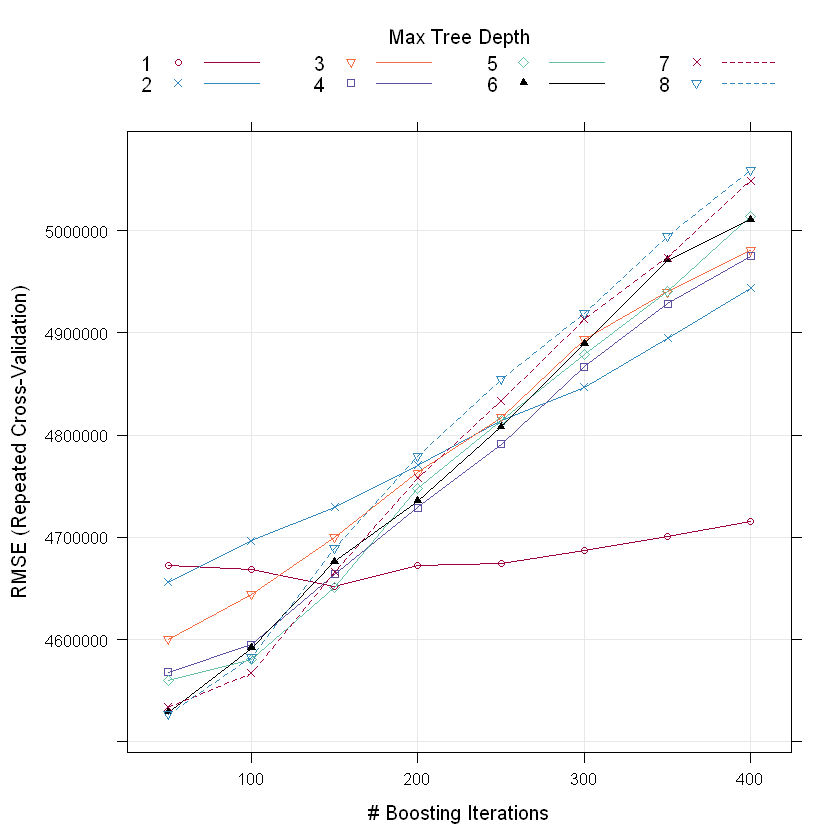

In [130]:
# Model training performance plot
plot(gbm_mod)

### Let's check if FW codigestion has any effect for the dairy farms

In [133]:
# Filter data to get only projects that treat dairy waste
df3 <- filter(df2,
             DairyAmount > 0)
df3 <- df3[c(1:2,8,11:14)]

In [139]:
# Train a random forest model
set.seed(0)
rf_mod <- train(ElectricitykWhyr ~ ., data = df3[c(-7,-3)], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [140]:
# Model performance
rf_mod

Random Forest 

209 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 188, 189, 188, 188, 188, 189, ... 
Resampling results across tuning parameters:

  mtry  RMSE     Rsquared   MAE    
   2    4691387  0.1515879  3203923
   4    4650912  0.1560878  3131945
   6    4656963  0.1593200  3131270
   8    4668786  0.1601563  3139875
  10    4679620  0.1599239  3150154
  12    4682395  0.1614475  3150926
  14    4686148  0.1608261  3152150
  16    4690209  0.1600160  3153022

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 4.

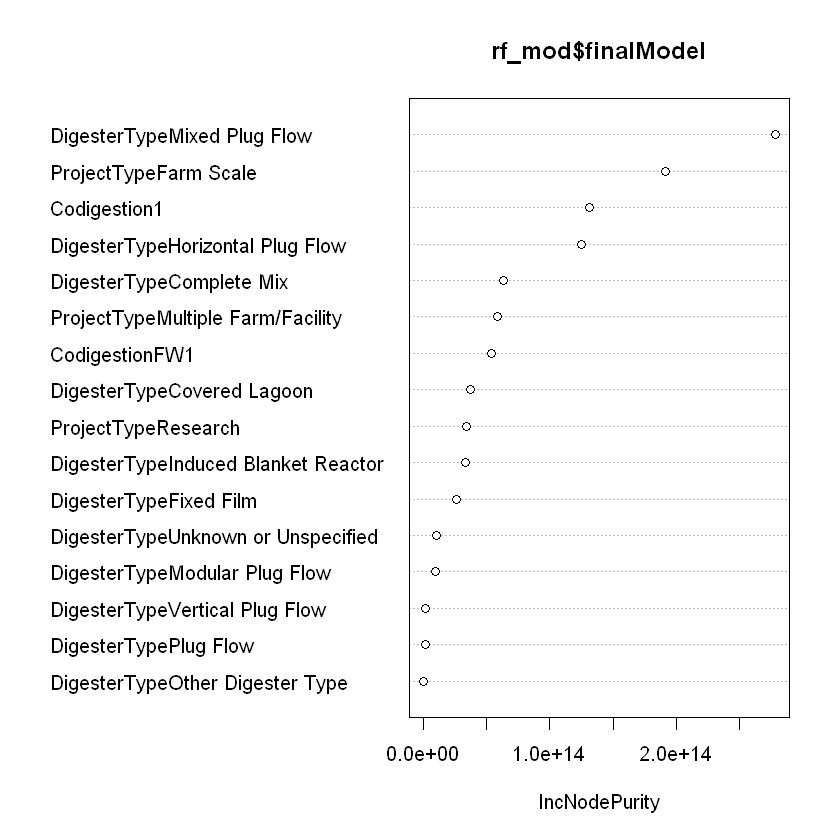

In [141]:
# Feature importance plot
varImpPlot(rf_mod$finalModel)

## 3. DEA on USA projects

In [142]:
# Create a new dataframe for the DEA and assign x and y variable values
x <- matrix(df3$DairyAmount)
y <- matrix(df3$ElectricitykWhyr)

In [143]:
# Run the DEA model (one input, one output, input-oriented)
e_vrs <- dea(x,y, RTS="vrs", ORIENTATION = "in")

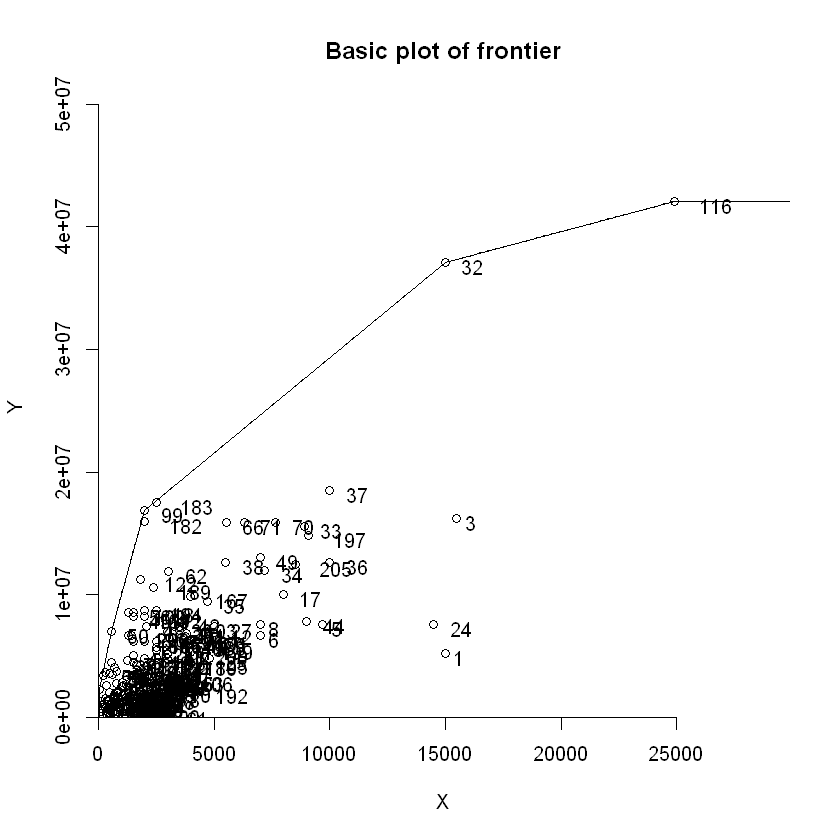

In [144]:
# Plot of different technologies with a title
dea.plot(x,y, txt=1:dim(x)[1],main="Basic plot of frontier")
dea.plot(x,y,RTS="vrs",add=TRUE,lty="dashed")

### Second stage of DEA: determinants of efficiency

In [145]:
#First we build a new df for regressing features on efficiency values
df4 <- df3
eff <- e_vrs$eff
df4$eff <- eff

In [146]:
str(df4)

'data.frame':	209 obs. of  8 variables:
 $ ProjectType         : Factor w/ 4 levels "Centralized/Regional",..: 2 2 2 2 2 3 2 2 2 2 ...
 $ DigesterType        : Factor w/ 12 levels "Anaerobic Sequencing Batch Reactor",..: 3 3 3 3 3 3 2 3 3 3 ...
 $ DairyAmount         : num  15000 4000 15500 1700 9700 ...
 $ Codigestion         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 2 1 ...
 $ CodigestionFW       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ElectricitykWhyr    : num  5256000 4467600 16206000 4204800 7600000 ...
 $ EmissionRedMetricTpy: num  138971 39353 108050 15014 82693 ...
 $ eff                 : num  0.0242 0.0699 0.1224 0.1479 0.0658 ...


In [147]:
# Efficiency model with cv and rf model
set.seed(0)
eff_mod_rf <- train(eff ~ ., data = df4[c(-3,-6,-7)], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [148]:
# Model performance summary
eff_mod_rf

Random Forest 

209 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 189, 188, 188, 188, 188, 189, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
   2    0.1793693  0.2172054  0.1160678
   4    0.1771551  0.2289686  0.1136806
   6    0.1778368  0.2268909  0.1140955
   8    0.1784004  0.2273055  0.1143362
  10    0.1797224  0.2215174  0.1150411
  12    0.1801635  0.2196373  0.1153448
  14    0.1810418  0.2162102  0.1158452
  16    0.1814443  0.2159537  0.1159014

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 4.

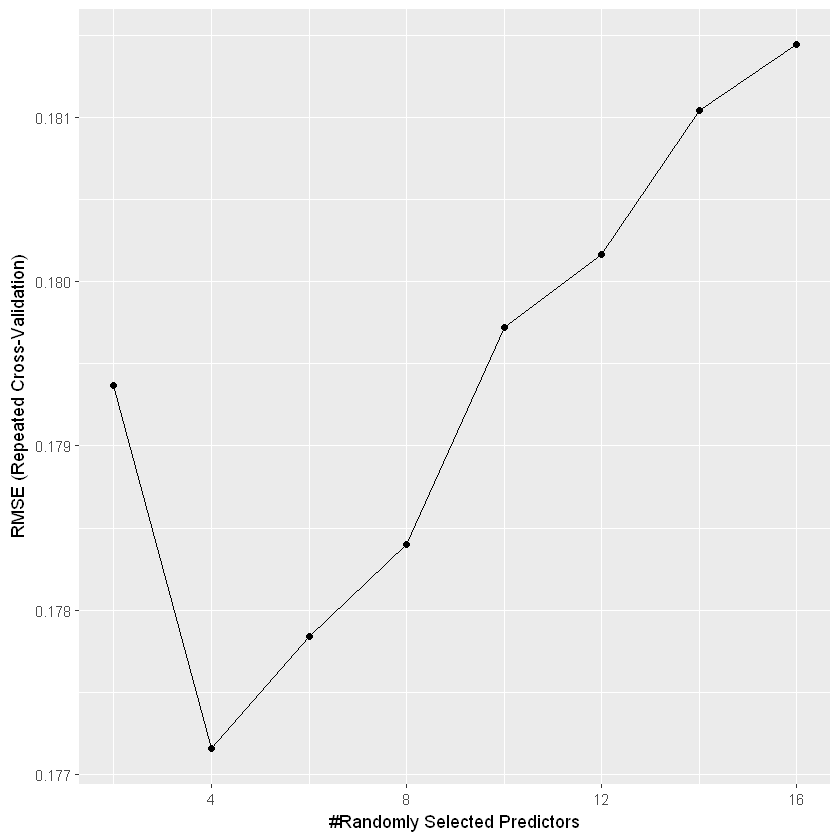

In [149]:
# Model training visualization
ggplot(eff_mod_rf)

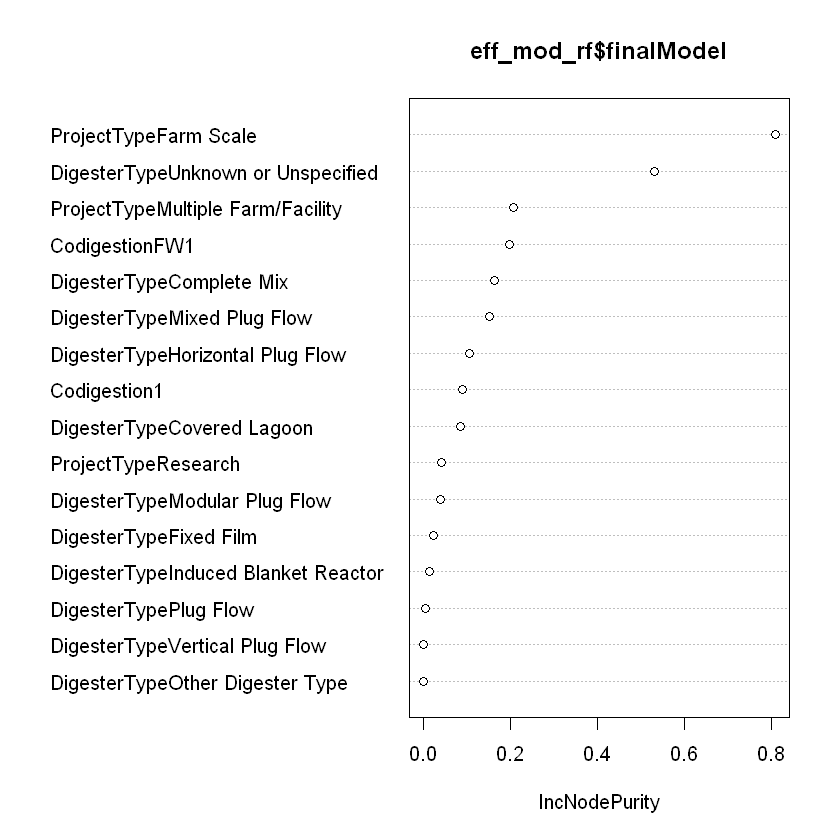

In [150]:
# Variable importance plot
varImpPlot(eff_mod_rf$finalModel)